In [6]:
# -------------- Import packages --------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import pickle
import arx #from https://github.com/Alymantara/arx
import time
from scipy.optimize import curve_fit
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.interpolate import interp1d
from scipy.stats import linregress
import linmix  # Ensure you have linmix installed for line fitting


In [7]:
# ===================================== Essential Function Library ============================================
def Locate_Star_ID(Star_File, Star_ID):
    """ Locate star(s) in the file by ID(s).
    
    Input:
    Star_File - Star data (pd dataframe).
    Star_ID - Star ID(s) (float or list).
    
    Output:
    Stars - pd dataframe containing selected stars by ID.
    """
    if type(Star_ID) == list:
        mask = Star_File['id_apass'].isin(Star_ID)
        Stars = Star_File[mask]
    else:
        Stars = Star_File.loc[Star_File['id_apass'] == Star_ID]
    return(Stars)

def Locate_Star_Filter(Star_File, Fltr):
    """ Locate star(s) in the file by filter(s).
    
    Input:
    Star_File - Star data (pd dataframe).
    Fltr - Filter(s) (string or list).
    
    Output:
    Stars - pd dataframe containing selected stars by filter.
    """
    if type(Fltr) == list:
        mask = Star_File['Filter'].isin(Fltr)
        Stars = Star_File[mask]
    else:
        Stars = Star_File.loc[Star_File['Filter'] == Fltr] 
    return(Stars)

def Locate_Star_Scope(Star_File, Telescope):
    """ Locate star(s) in the file by telescope(s).
    
    Input:
    Star_File - Star data (pd dataframe).
    Telescope - Telescope(s) (string or list).
    
    Output:
    Stars - pd dataframe containing selected stars by telescope.
    """
    if type(Telescope) == list:
        mask = Star_File['telid'].isin(Telescope)
        Stars = Star_File[mask]
    else:
        Stars = Star_File.loc[Star_File['telid'] == Telescope]
    return(Stars)

def Locate_Star_Epoch(Star_File, Epoch):
    """ Locate star(s) in the file by Epoch(s).
    
    Input:
    Star_File - Star data (pd dataframe).
    Epoch - MJD(s) (string or list).
    
    Output:
    Stars - pd dataframe containing selected stars by epoch.
    """
    if type(Epoch) == list:
        mask = Star_File['MJD'].isin(Epoch)
        Stars = Star_File[mask]
    else:
        Stars = Star_File.loc[Star_File['MJD'] == Epoch]
    return(Stars)

def Generic_Optimal(Data, Errors):
    """ Compute inverse variance weighted average.
    
    Input:
    Data - Data to average (list/array).
    Errors - Errors of data to average (list/array).
    
    Output:
    avg - Optimal average (float).
    err - standard deviation of average (float).
    """
    
    #errors handled by returning nan values
    #ensure data are in arrays
    var = np.array(Errors)**2
    Data = np.array(Data)
    
    if len(var) != 0:
        try:
            w = 1/var
            avg = np.nansum(w*Data) / np.nansum(w)
            var = 1/np.nansum(w)
        except:
            avg = np.nan
            var = np.nan
    else:
        avg = np.nan
        var = np.nan
    
    if var**0.5 == np.inf:
        var == np.nan
        avg == np.nan
    
    err = var**0.5
    return(avg, err)

def root_mean_squared_deviation(data, mean):
    """Compute rms of dataset.
    Input:
    data - dataset to compute rms for (array/list).
    mean - mean of dataset (float).
    
    Output:
    rms - root mean squared deviation (float).
    """
    
    rms = (sum((data-mean)**2) / (len(data) - 1))**0.5
    return(rms)

def Brightest_Reduced(Star_File, Filter, Target_ID = 0.0, frac = 0.5):
    """ IDs of the brightest stars in the data for a specific filter, identified using optimal average. 
        Only include stars that have more than specified number of data points per star (frac).
    
    Input:
    Star_File - Star data (pd dataframe).
    Filter - Filter (string).
    Target_ID - ID of target of interest (int).
    frac - (Optional) Fraction of max number of epochs to keep (float).
    
    Output:
    Brightest_IDs - IDs of stars sorted from brightest to dimmest (list).
    """
    
    #Select specified filter data
    Star_Data0 = Locate_Star_Filter(Star_File, Filter)
    
    #Make sure Target of interest isn't included
    Star_IDs = [k for k in pd.unique(Star_Data0['id_apass']) if k!= Target_ID]
    
    Max_length = 0.0  
    #Get max number of epochs amongst all stars
    for ID in Star_IDs:
        Star_Data = Locate_Star_ID(Star_Data0, ID)
        if len(Star_Data['MJD'].values) > Max_length:
            Max_length = len(Star_Data['MJD'].values)
    
    #Select all stars with more than specified number of datapoints
    keep_dp = frac * Max_length
    Reduced_IDs = []
    for ID in Star_IDs:     
        Star_Data = Locate_Star_ID(Star_Data0, ID)
        if len(Star_Data['MJD'].values) > keep_dp:
            Reduced_IDs.append(ID)
    
    #Compute optimal average of instrumental magnitudes
    MAGS = []
    IDS = []
    for ID in Reduced_IDs:
        Star_Data = Locate_Star_ID(Star_Data0, ID)
        mag = Star_Data['mag_aper'].values
        mag_err = Star_Data['err_aper'].values
        mag_mean = Generic_Optimal(mag, mag_err)[0]
        MAGS.append(mag_mean)
        IDS.append(ID)
    
    #Sort from brightest to dimmest and return IDs
    MAGS_ref = MAGS
    MAGS = sorted(MAGS)
    Brightest_indices = [MAGS_ref.index(i) for i in MAGS]
    Brightest_IDs = list(np.array(IDS)[np.array(Brightest_indices)])
    return Brightest_IDs


def Target_Calb(Data, Calibrated_Star_Data, Filter, err_th = 0.05, Plot = True, Rem_out = True, Target_ID = 0.0, zp = [0.,0.]):
    """ Return Dataframe with calibrated Lightcurve. Choose whether to leave in outliers.
        Can also plot the lightcurve.
    
    Input:
    Data - original list of star data arrays that was inputed to do the calibration (list).
    Calibrated_Star_Data - Calibrated star dataframe from Corr() function (pd dataframe).
    Filter - Filter (string).
    err_th - (Optional) Error threshold for clipping outliers.
    Plot - (Optional) Choose whether to display the error distributions and lightcurves (Bool).
    Rem_out = (Optional) Choose whether to remove outliers from returned target dataframe (Bool).
    Target_ID - the ID of your interested target to calibrate
    zp - zeropoints and error for photometric calibration (list)
    
    Output:
    Target_DF - dataframe containing calibrated lightcurve.
   """
    
    if len(Data) == 6:
        Original_Star_File = pd.DataFrame({'MJD': Data[0], 'Filter': Data[1], 'id_apass': Data[2], 'mag_aper': Data[3], 'err_aper': Data[4], 'telid': Data[5], 'airmass': [np.nan]*len(Data[5]), 'seeing': [np.nan]*len(Data[5])})
    elif len(Data) == 7: 
        Original_Star_File = pd.DataFrame({'MJD': Data[0], 'Filter': Data[1], 'id_apass': Data[2], 'mag_aper': Data[3], 'err_aper': Data[4], 'telid': Data[5], 'airmass': Data[6], 'seeing': [np.nan]*len(Data[5])})
    elif len(Data) == 8: 
        Original_Star_File = pd.DataFrame({'MJD': Data[0], 'Filter': Data[1], 'id_apass': Data[2], 'mag_aper': Data[3], 'err_aper': Data[4], 'telid': Data[5], 'airmass': Data[6], 'seeing': Data[7]})
    else:
        print('Your file has the wrong length...')
        Original_Star_File = np.nan
    
    TEL = list(pd.unique(Calibrated_Star_Data.telid))
    Star_Data = Calibrated_Star_Data
   
    #Set up dataframe ==========================================
    columns = ['Filter','telid', 'MJD', 'mag', 'err', 'err_sys']
    Target_DF = pd.DataFrame(columns=columns)
    font = 'Cambria'
    Target_Data = Locate_Star_ID(Locate_Star_Filter(Original_Star_File, Filter), Target_ID)
    
    for scope in TEL:
        #Select data based on telescope
        Target_Data2 = Locate_Star_Scope(Target_Data, scope)
        for E in pd.unique(Target_Data2['MJD']):
            
            #Select data based on Epoch
            Target_Data3 = Locate_Star_Epoch(Target_Data2, E)
            Star_Data2 = Locate_Star_Epoch(Locate_Star_Filter(Locate_Star_Scope(Star_Data, scope), Filter), E).head(1)
            
            #Assuming the target has a datapoint for that epoch...
            if len(Star_Data2) != 0:
                
                #Apply correction parameters
                Target_mag = Target_Data3['mag_aper'].values - Star_Data2['DMAGT'].values - Star_Data2['DMAGS'].values + zp[0]
                Target_mag_err = (Target_Data3['err_aper'].values[0]**2 + Star_Data2['rms_sc'].values[0]**2 + Star_Data2['rms_t'].values[0]**2)**0.5
                Target_DF = pd.concat([Target_DF, pd.DataFrame([pd.Series({'Filter': Filter, 'telid': scope, 'MJD': E, 'mag':Target_mag[0], 'err': Target_mag_err, 'err_sys': Target_mag_err*0.0+zp[1]})], columns = pd.Series({'Filter': Filter, 'telid': scope, 'MJD': E, 'mag': Target_mag[0], 'err': Target_mag_err, 'err_sys': Target_mag_err*0.0+zp[1]}).index)]).reset_index(drop=True)
    

    if Plot == True:
        print('======================================================== ' + Filter + ' Filter' + ' ========================================================')
        #COLORS = ['navy', 'green', 'blue', 'orange', 'purple', 'yellow', 'skyblue', 'violet', 'darkgreen', 'maroon']

        import random
        COLORS = ["#{:06x}".format(random.randint(0, 0xFFFFFF)) for _ in range(len(TEL))]
        T_no = len(TEL)
        num_of_plots = (T_no - 1) // 5 + 1
        
        if len(TEL) < 5:
            if len(TEL) == 1:
                #small adjustment here if only one telescope is being used
                fig0, ax0 = plt.subplots(1, 2, sharex = False, figsize = (20, 2.5*1))
                ax0 = ax0.reshape(1, 2)
            else:
                fig0, ax0 = plt.subplots(num_of_plots, len(TEL), sharex = False, figsize = (20, 2.5*num_of_plots))
                ax0 = ax0.reshape(1, len(TEL))
        else:
            fig0, ax0 = plt.subplots(num_of_plots, 5, sharex = False, figsize = (20, 2.5*num_of_plots))
        
        fig0.subplots_adjust(wspace=0.1, hspace = 0.4)
        
        fig, ax = plt.subplots(1,1,figsize=(15, 3.5), sharex = False)
        fig.subplots_adjust(wspace=0.1, hspace = 0.25)
        ax.set_title('Uncalibrated Target Lightcurve', fontproperties = font, size = 15)
        ax.set_xlabel('MJD',fontproperties = font, size = 15)
        ax.set_ylabel('Mag',fontproperties = font, size = 15)
        ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6, top = True, right = True)
        ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4, top = True, right = True)
        ax.minorticks_on()
        ax.invert_yaxis()

        fig2, (ax2, ax3) = plt.subplots(2,1,figsize=(15, 7))
        fig2.subplots_adjust(wspace=0.1, hspace = 0.25)

        lab = 'Mag'
        
        ax2.set_title('Calibrated Target Lightcurve',fontproperties = font, size = 15)
        ax2.set_ylabel(lab, fontproperties = font, size = 15)
        ax2.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6, top = True, right = True)
        ax2.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4, top = True, right = True)
        ax2.minorticks_on()
        ax2.invert_yaxis()
        ax2.set_xlabel('MJD',fontproperties = font, size = 15)

        
        clipped = len(Target_DF.loc[Target_DF['err'] > err_th])
        #ax3.set_title('Calibrated AGN Lightcurve without outliers  |  '+ 'Datapoints Clipped: ' +str(int(clipped))+' out of '+str(len(Target_DF))+'  |  Outlier error threshold: '+ str(round(100*err_th, 1)) + '%',fontproperties = font, size = 15)
        ax3.set_ylabel(lab, fontproperties = font, size = 15)
        ax3.set_xlabel('MJD',fontproperties = font, size = 15)
        ax3.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6, top = True, right = True)
        ax3.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4, top = True, right = True)
        ax3.minorticks_on()
        ax3.invert_yaxis()
        
        r = 0
        c = 0
        
        MA = 0.
        MI = 10000
        
        #Plot error distributions
        for scope in TEL:
            dat = Locate_Star_Scope(Target_DF, scope)
            dat2 = dat.loc[dat['err'] < err_th]
            
            if len(dat) > 0:
                nbins = int(len(dat) / 2)
                if nbins == 0:
                    nbins = 1
                hist = ax0[r, c].hist(dat['err'].values, bins = nbins, alpha = 0.7, density = False, color = COLORS[TEL.index(scope)], edgecolor = 'black')
                ax0[r, c].vlines(err_th, 0, max(hist[0]), lw = 1.2, ls = '--', color = 'red', label = 'Outlier Threshold: '+ str(err_th))

                #Old mad selection
                #ax0[r, c].vlines(np.median(dat['err'].values), 0, max(hist[0]), lw = 1, ls = '--', color = 'maroon', label = 'Median: '+ str(round(np.median(dat['err'].values), 6)))
                #MAD = np.sum(abs(errors[TEL.index(scope)] - np.median(errors[TEL.index(scope)]))) / len(errors[TEL.index(scope)])
                #ax0[r, c].axvspan(np.median(dat['err'].values) - MAD, np.median(dat['err'].values) + MAD, alpha=0.1, color='red',label = 'MAD')
                #ax0[r, c].axvspan(np.median(dat['err'].values) - 2*MAD, np.median(dat['err'].values) + 2*MAD, alpha=0.1, color='orange',label = '2*MAD')

                ax0[r,c].legend()
                ax0[r,c].tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
                ax0[r,c].tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
                ax0[r,c].minorticks_on()
                ax0[r,c].set_title(str(scope) + '  |  No. of datapoints: '+ str(len(dat['err'].values)))
                ax0[r,c].set_xlabel('Total error')
    
            if c < 4:
                c = c + 1
            else:
                r = r + 1
                c = 0
                        
            #Plot uncalibrated data
            ax.scatter(Locate_Star_Scope(Target_Data, scope)['MJD'], Locate_Star_Scope(Target_Data, scope)['mag_aper'], s = 5, label = scope, color = COLORS[TEL.index(scope)])
            
            F = dat['mag']
            F_err = dat['err']
            F2 = dat2['mag']
            F2_err = dat2['err']
                
            #Plot calibrated data with errors
            if len(F) > 0:
                if MA < max(F):
                    MA = max(F)
                if MI > min(F):
                    MI = min(F)
                ax2.scatter(dat['MJD'], F, s = 5, color = COLORS[TEL.index(scope)], label = scope)
                ax2.errorbar(dat['MJD'], F, yerr = F_err, lw = 0.5, color = COLORS[TEL.index(scope)], ls = 'none')
                #Plot calibrated data without errors
                ax3.scatter(dat2['MJD'], F2, s = 5, color = COLORS[TEL.index(scope)], label = scope)
                ax3.errorbar(dat2['MJD'], F2, yerr = F2_err, lw = 0.5, color = COLORS[TEL.index(scope)], ls = 'none')
        #print(MA - MI)
        ax.set_xticks(np.arange(int(min(Target_Data['MJD'])), int(max(Target_Data['MJD']))+200, 200), labels = np.arange(int(min(Target_Data['MJD'])), int(max(Target_Data['MJD']))+200, 200), fontproperties = font, size = 15)
        ax2.set_xticks(np.arange(int(min(Target_Data['MJD'])), int(max(Target_Data['MJD']))+200, 200), labels = np.arange(int(min(Target_Data['MJD'])), int(max(Target_Data['MJD']))+200, 200), fontproperties = font, size = 15)
        ax3.set_xticks(np.arange(int(min(Target_Data['MJD'])), int(max(Target_Data['MJD']))+200, 200), labels = np.arange(int(min(Target_Data['MJD'])), int(max(Target_Data['MJD']))+200, 200), fontproperties = font, size = 15)

        ax.legend(loc = 'right')
        ax2.legend(loc = 'right')
        ax3.legend(loc = 'right')
        
    if Rem_out == True:
        print('Returning dataframe with outliers taken out')
        Target_DF = Target_DF.loc[Target_DF['err'] < err_th]
        return Target_DF
    else:
        print('Returning dataframe with outliers kept in')
        return Target_DF

def Convergence_Plot(Traces, mode, parameter, TEL, parameter_err = None, lim = 20, zoom = 0):
    """ Plots of traces of intercalibration algorithm to visualy check convergence.
    
    Input:
    Traces - Traces output from Corr() (list).
    mode - 'double' or 'single' (str): 
            double: Plots the trace of a parameter AND its error as a shell around the plot.
            single: Plots any ONE parameter from the list above. Can be used to check the convergence of the errors themselves for example.
    parameter - parameter to check convergence for (str). parameters include: 'dmagt', 'dmagt_err', 'rms_t', 'rms_t_err', 'DMAGT', 'DMAGT_err', 'dmags', 'dmags_err', 'rms_sc',
             'rms_sc_err', 'm_star', 'm_star_err', 'rms_star', 'rms_star_err', 'DMAGS', 'DMAGS_err'.
    TEL - list of telescopes for a specific filter.
    parameter_err - (Optional) if mode = 'double', parameter error (str).
    lim - (Optional) number of plots to show for epoch & star_mag related parameters as there can be a lot of them (int).
    zoom - (Optional) zoom into convergence tail to check finer fluctuations (int).
    """
    
    #Possible parameters to check
    names = ['dmagt', 'dmagt_err', 'rms_t', 'rms_t_err', 'DMAGT', 'DMAGT_err', 'dmags', 'dmags_err', 'rms_sc',
             'rms_sc_err', 'm_star', 'm_star_err', 'rms_star', 'rms_star_err', 'DMAGS', 'DMAGS_err']
    scope_pars = ['dmags', 'dmags_err', 'rms_sc','rms_sc_err', 'DMAGS', 'DMAGS_err']
    time_pars = ['dmagt', 'dmagt_err', 'rms_t','rms_t_err', 'DMAGT', 'DMAGT_err']
    star_pars = ['m_star', 'm_star_err', 'rms_star', 'rms_star_err']
    iterations = len(Traces[-1])    
    if mode == 'single':
        par = Traces[names.index(parameter)]
            
        if parameter in scope_pars:
            import random
            COLORS = ["#{:06x}".format(random.randint(0, 0xFFFFFF)) for _ in range(len(TEL))]

            #Set up plot
            T_no = len(TEL)
            num_of_plots = (T_no - 1) // 5 + 1
            
            if len(TEL) < 5:
                fig, ax = plt.subplots(num_of_plots, len(TEL), sharex = False, figsize = (20, 2.5*num_of_plots))
                ax = ax.reshape(1, len(TEL))
            else:
                fig, ax = plt.subplots(num_of_plots, 5, sharex = False, figsize = (20, 2.5*num_of_plots))
                fig.subplots_adjust(wspace=0.3, hspace = 0)

            #Iteration number
            IT = np.arange(1, iterations + 1, 1)[zoom:]
            
            r = 0
            c = 0
            for j in range(len(TEL)):
                D = []
                for i in range(len(par)):
                    D.append(par[i][j])
                D = D[zoom:]

                ax[r, c].plot(IT, D, label = 'Scope: ' + str(TEL[j]), color = COLORS[j], lw = 0.8)
                ax[r, c].legend()

                if r == 1:
                    ax[r, c].set_xlabel('Iteration')
                if c == 0:
                    ax[r,c].set_ylabel(parameter)

                if c < 4:
                    c = c + 1
                else:
                    r = r + 1
                    c = 0
        
        elif parameter in time_pars:
            SCOPE = 0
            IT = np.arange(1, iterations + 1, 1)[zoom:]
            r = 0
            c = 0            
            if lim < 4:
                lim = 4
            fig, ax = plt.subplots(math.ceil(lim / 4), 4, sharex = True, figsize = (30,20))
            fig.subplots_adjust(wspace=0.2, hspace = 0)
            for i in range(lim):
                D = []
                for j in range(len(par)):
                    D.append(par[j][SCOPE][i])
                D = D[zoom:]
                ax[r, c].plot(IT, D, label = 'MJD: ' + str(i), lw = 0.8)
                ax[r, c].legend()
                ax[r, c].ticklabel_format(useOffset=False)

                if r > math.ceil(lim / 4) - 4:
                    ax[r, c].set_xlabel('Iteration')
                if c == 0:
                    ax[r,c].set_ylabel(parameter)

                if c < 3:
                    c = c + 1
                else:
                    c = 0
                    r = r + 1

        elif parameter in star_pars:
            IT = np.arange(1, iterations + 1, 1)[zoom:]
            r = 0
            c = 0

            if lim < 5:
                lim = 5

            fig,ax = plt.subplots(math.ceil(lim / 5), 5, sharex = True, sharey = False, figsize = (20, 10))
            fig.subplots_adjust(wspace=0.4, hspace = 0)
            for j in range(lim):
                D = []
                for i in range(len(par)):
                    D.append(par[i][j])
                D = D[zoom:]
                ax[r, c].plot(IT, D, lw = 0.8)
                ax[r, c].ticklabel_format(useOffset=False)

                if r > math.ceil(lim / 5) - 5:
                    ax[r, c].set_xlabel('Iteration')
                if c == 0:
                    ax[r,c].set_ylabel(parameter)

                if c < 4:
                    c = c + 1
                else:
                    c = 0
                    r = r + 1         
    
    elif mode == 'double':
        
        if parameter_err == None:
            raise ValueError("With 'double' mode, par and par_err must be specified.")
        
        else:
            par = Traces[names.index(parameter)]
            par_err = Traces[names.index(parameter_err)]
            
            if parameter in scope_pars:
                COLORS = ['red', 'green', 'blue', 'purple', 'black', 'gray', 'violet', 'teal', 'orange', 'yellow']

                #Set up plot
                fig,ax = plt.subplots(2,5, sharex = True, figsize = (20, 10))
                fig.subplots_adjust(wspace=0.3, hspace = 0)

                #Iteration number
                IT = np.arange(1, iterations + 1, 1)[zoom:]
                r = 0
                c = 0
                for j in range(10):
                    D = []
                    D_err = []
                    for i in range(len(par)):
                        D.append(par[i][j])
                        D_err.append(par_err[i][j])
                    D = D[zoom:]
                    D_err = D_err[zoom:]
                    
                    ax[r, c].plot(IT, D, label = 'Scope: ' + str(TEL[j]), color = COLORS[j], lw = 0.8)
                    ax[r, c].legend()

                    ax[r, c].plot(IT, np.array(D) + np.array(D_err), color = COLORS[j], lw = 0.8, ls = '--')
                    ax[r, c].plot(IT, np.array(D) - np.array(D_err), color = COLORS[j], lw = 0.8, ls = '--')
                    ax[r, c].fill_between(IT, np.array(D) - np.array(D_err), np.array(D) + np.array(D_err), color = COLORS[j], alpha = 0.3)

                    if r == 1:
                        ax[r, c].set_xlabel('Iteration')
                    if c == 0:
                        ax[r,c].set_ylabel(parameter)

                    if c < 4:
                        c = c + 1
                    else:
                        c = 0
                        r = r + 1
            elif parameter in time_pars:
                SCOPE = 0
                IT = np.arange(1, iterations + 1, 1)[zoom:]
                r = 0
                c = 0            
                if lim < 4:
                    lim = 4
                fig, ax = plt.subplots(math.ceil(lim / 4), 4, sharex = True, figsize = (30,20))
                fig.subplots_adjust(wspace=0.2, hspace = 0)
                for i in range(lim):
                    D = []
                    D_err = []
                    for j in range(len(par)):
                        D.append(par[j][SCOPE][i])
                        D_err.append(par_err[j][SCOPE][i])
                    D = D[zoom:]
                    D_err = D_err[zoom:]
                    ax[r, c].plot(IT, D, label = 'MJD: ' + str(i), lw = 0.8)
                    ax[r, c].legend()
                    ax[r, c].ticklabel_format(useOffset=False)

                    ax[r, c].plot(IT, np.array(D) + np.array(D_err), lw = 0.8, ls = '--', color = 'blue')
                    ax[r, c].plot(IT, np.array(D) - np.array(D_err), lw = 0.8, ls = '--', color = 'blue')
                    ax[r, c].fill_between(IT, np.array(D) - np.array(D_err), np.array(D) + np.array(D_err), alpha = 0.3)

                    if r > math.ceil(lim / 4) - 4:
                        ax[r, c].set_xlabel('Iteration')
                    if c == 0:
                        ax[r,c].set_ylabel(parameter)

                    if c < 3:
                        c = c + 1
                    else:
                        c = 0
                        r = r + 1

            elif parameter in star_pars:
                IT = np.arange(1, iterations + 1, 1)[zoom:]
                r = 0
                c = 0

                if lim < 5:
                    lim = 5

                fig,ax = plt.subplots(math.ceil(lim / 5), 5, sharex = True, sharey = False, figsize = (20, 10))
                fig.subplots_adjust(wspace=0.4, hspace = 0)
                for j in range(lim):
                    D = []
                    D_err = []
                    for i in range(len(par)):
                        D.append(par[i][j])
                        D_err.append(par_err[i][j])
                    D = D[zoom:]
                    D_err = D_err[zoom:]
                    ax[r, c].plot(IT, D, lw = 0.8)
                    ax[r, c].ticklabel_format(useOffset=False)

                    ax[r, c].plot(IT, np.array(D) + np.array(D_err), lw = 0.8, ls = '--')
                    ax[r, c].plot(IT, np.array(D) - np.array(D_err), lw = 0.8, ls = '--')
                    ax[r, c].fill_between(IT, np.array(D) - np.array(D_err), np.array(D) + np.array(D_err), alpha = 0.3)

                    if r > math.ceil(lim / 5) - 5:
                        ax[r, c].set_xlabel('Iteration')
                    if c == 0:
                        ax[r,c].set_ylabel(parameter)

                    if c < 4:
                        c = c + 1
                    else:
                        c = 0
                        r = r + 1
    else:
        raise ValueError(str(mode) + " is not a valid mode input. Please select either 'single' or 'double'.")

def Corr(Data, Filter, MAX_LOOPS = 100, bad_IDs = [], safe = 0.6, frac = 0.5, Target_ID = 0.0, Star_Lim = 100):
    """Algorithm to compute telescope correction parameters, star magnitudes, and extra variance as well as their errors.
    
    Input:
    Data - Arrays of required data (list).
    Filter - Filter (String).
    MAX_LOOPS - (Optional) Max number of loops if convergence isn't reached (int).
    bad_IDs - (Optional) Star IDs to omit in the calibration, primarily meant for variable stars (list/array).
    safe - (Optional) Safety step size to avoid overstepping (float).
    frac - (Optional) Fraction of stars with number of datapoints above max number of epochs (float).
    Target_ID - ID for target of interest (float)
    Star_Lim = Max number of stars to be used in the calibration (int)
    
    Output:
    df - dataframe containing final correction parameters, extra variances, their errors and their corrected magnitudes (pd dataframe)
    TRACES - Traces of the correction parameters (arrays)
    """
    # ======================= Select stars to use in calibration ========================
    
    start_time = time.time()

    #Create panda dataframe with given arrays
    if len(Data) == 6:
        Star_File = pd.DataFrame({'MJD': Data[0], 'Filter': Data[1], 'id_apass': Data[2], 'mag_aper': Data[3], 'err_aper': Data[4], 'telid': Data[5], 'airmass': [np.nan]*len(Data[5]), 'seeing': [np.nan]*len(Data[5])})
    elif len(Data) == 7: 
        Star_File = pd.DataFrame({'MJD': Data[0], 'Filter': Data[1], 'id_apass': Data[2], 'mag_aper': Data[3], 'err_aper': Data[4], 'telid': Data[5], 'airmass': Data[6], 'seeing': [np.nan]*len(Data[5])})
    elif len(Data) == 8: 
        Star_File = pd.DataFrame({'MJD': Data[0], 'Filter': Data[1], 'id_apass': Data[2], 'mag_aper': Data[3], 'err_aper': Data[4], 'telid': Data[5], 'airmass': Data[6], 'seeing': Data[7]})
    else:
        print('Your file has the wrong length')
        Star_File = np.nan

    
    #Select stars based on fraction of datapoints
    Star_IDs = Brightest_Reduced(Star_File, Filter, frac = frac, Target_ID = Target_ID)
    
    #Further select stars based on variability if bad IDs are specified
    if len(bad_IDs) > 0:
        Star_IDs = [i for i in Star_IDs if i not in bad_IDs]
    
    #Max number of stars to use
    if Star_Lim != None and len(Star_IDs) > Star_Lim:
        Star_IDs = Star_IDs[:Star_Lim]
    
    #Total number of stars used in calibration
    Nstars = len(Star_IDs)
    print('No. of Stars: '+ str(Nstars))
    
    #Select star data based on filter and star IDs
    Star_Data = Locate_Star_Filter(Locate_Star_ID(Star_File, Star_IDs), Filter)
    TEL = pd.unique(Star_Data.telid)
    
    # ====================== Dataframes to return at the end ============================
    
    #Length of correction parameter dataframe
    df_length = len(Star_Data['id_apass'].values)
    
    #'scope_mean' and 'scope_mean_err' are temporary and meaningless at the end, just used to speed up computation
    df = pd.DataFrame({'id_apass': Star_Data['id_apass'].values, 'Filter': Star_Data['Filter'].values,
                       'MJD': Star_Data['MJD'].values, 'telid': Star_Data['telid'].values, 
                       'scope_mean': df_length*[0.], 'scope_mean_err': df_length*[0.],
                       'mag_aper': Star_Data['mag_aper'].values, 'err_aper': Star_Data['err_aper'].values,
                       'dmagt': df_length*[0.], 'dmagt_err': df_length*[0.], 'rms_t': df_length*[0.],
                       'rms_t_err': df_length*[0.], 'dmags': df_length*[0.], 'dmags_err': df_length*[0.],
                       'rms_sc':df_length*[0.], 'rms_sc_err': df_length*[0.], 'm_star': df_length*[0.],
                       'm_star_err': df_length*[0.], 'rms_star': df_length*[0.], 'rms_star_err': df_length*[0.],
                       'err_tot': Star_Data['err_aper'].values, 'DMAGT': df_length*[0.], 'DMAGS': df_length*[0.],
                       'DMAGT_err': df_length*[0.], 'DMAGS_err': df_length*[0.],
                       'airmass': Star_Data['airmass'].values, 'seeing': Star_Data['seeing'].values}) 
    
    df.set_index(Star_Data.index.values)
    
    # ==================================== Traces ====================================
    
    epochs = []
    dmagts = [] ; dmagts_err = []
    rms_ts = [] ; rms_ts_err = []
    dmagss = [] ; dmagss_err = []
    rms_scs = [] ; rms_scs_err = []
    mstars = [] ; mstars_err = []
    rms_stars = [] ; rms_stars_err = []
    DMAGTS = [] ; DMAGTS_err = []
    DMAGSS = [] ; DMAGSS_err = []
    
    # ============================== Intercalibration =================================
    
    star_mag_correction = 0.
    loop = 0
    
    while loop < MAX_LOOPS:
        # ---------------------------------  1.dmagt  -------------------------------
        if __name__ == "__main__":
            df = process_dataframe_parallel2(df, loop, safe, Star_IDs)
 
        # ---------------------------------- 2.dmags --------------------------------
        #Compute temporary mean of star using optimal average
        for ID in Star_IDs:
            
            #Select data for particular telescope
            Star_Data_S = Locate_Star_ID(df, ID)
            Mag = Star_Data_S['mag_aper'].values
            Err = Star_Data_S['err_tot'].values
            Mean, Mean_err = Generic_Optimal(Mag, Err)
            
            #Update dataframe
            df['m_star'] = np.where((df['id_apass'] == ID), Mean, df['m_star'])
            df['m_star_err'] = np.where((df['id_apass'] == ID), Mean_err, df['m_star_err'])
        
        if __name__ == "__main__":
            df = process_dataframe_parallel3(df, loop, safe, Star_IDs)
            
        
        dat = df
        initial_DMAGS = (dat.DMAGS + dat.dmags).values
        DMAGS_mean, DMAGS_mean_err = Generic_Optimal(initial_DMAGS, dat['dmags_err'].values)
        
        Corr1 = dat.dmags - DMAGS_mean
        
        #Propagate error in new dmagt accordingly
        CorrE = (dat.dmags_err**2 + DMAGS_mean_err**2)**0.5
        
        #Update dataframe
        df.loc[Corr1.index, 'dmags'] = Corr1
        df.loc[CorrE.index, 'dmags_err'] = CorrE
        df.loc[CorrE.index, 'DMAGS_err'] = CorrE
        
        #Updated dataframe
        dat = df
        Corr2 = dat.DMAGS + dat.dmags
        
        #Update dataframe
        df.loc[Corr2.index, 'DMAGS'] = Corr2
        
        # ---------------------------------- 3.m(*) --------------------------------
        
        if __name__ == "__main__":
            df = process_dataframe_parallel4(df, loop, safe)
        
        first_star_corr = Locate_Star_ID(df, Star_IDs[0])['m_star'].values[0]

        df['mag_aper'] = df['mag_aper'].values - first_star_corr
        df['m_star'] = df['m_star'].values - first_star_corr

        #Keep track of how much the data shifts in total
        star_mag_correction = star_mag_correction + first_star_corr
        
        #Update traces
        epochs_temp = []
        dmagts_temp = [] ; dmagts_err_temp = []
        rms_t_temp = [] ; rms_t_err_temp = []
        DMAGTS_temp = [] ; DMAGTS_err_temp = []
        dmagss_temp = [] ; dmagss_err_temp = []
        DMAGSS_temp = [] ; DMAGSS_err_temp = []
        rms_sc_temp = [] ; rms_sc_err_temp = []
        
        for Telescope in TEL:

            Star_Data_T = Locate_Star_Scope(df, Telescope)
            dat = Star_Data_T.sort_values('MJD')
            if len(dat) > 0:
                unique_epochs = pd.unique(dat['MJD'])
                all_epochs = dat['MJD'].values
                unique_epoch_ind = np.array([list(all_epochs).index(e) for e in unique_epochs])
                
                epochs_temp.append(dat['MJD'].values[unique_epoch_ind])
                dmagts_temp.append(dat['dmagt'].values[unique_epoch_ind]) ; dmagts_err_temp.append(dat['dmagt_err'].values[unique_epoch_ind])
                rms_t_temp.append(dat['rms_t'].values[unique_epoch_ind]) ; rms_t_err_temp.append(dat['rms_t_err'].values[unique_epoch_ind])
                DMAGTS_temp.append(dat['DMAGT'].values[unique_epoch_ind]) ; DMAGTS_err_temp.append(dat['DMAGT_err'].values[unique_epoch_ind])
                
    
                dmagss_temp.append(dat['dmags'].values[0]) ; dmagss_err_temp.append(dat['dmags_err'].values[0])
                DMAGSS_temp.append(dat['DMAGS'].values[0]) ; DMAGSS_err_temp.append(dat['DMAGS_err'].values[0])
                rms_sc_temp.append(dat['rms_sc'].values[0]) ; rms_sc_err_temp.append(dat['rms_sc_err'].values[0])
            else:
                epochs_temp.append(np.array([np.nan]))
                dmagts_temp.append(np.array([np.nan]))
                rms_t_temp.append(np.array([np.nan]))
                DMAGTS_temp.append(np.array([np.nan]))
                dmagss_temp.append(np.array([np.nan]))
                DMAGSS_temp.append(np.array([np.nan]))
                rms_sc_temp.append(np.array([np.nan]))
        epochs.append(np.array(epochs_temp, dtype = object))
        dmagts.append(np.array(dmagts_temp, dtype = object)) ; dmagts_err.append(np.array(dmagts_err_temp, dtype = object))
        rms_ts.append(np.array(rms_t_temp, dtype = object)) ; rms_ts_err.append(np.array(rms_t_err_temp, dtype = object))
        DMAGTS.append(np.array(DMAGTS_temp, dtype = object)) ; DMAGTS_err.append(np.array(DMAGTS_err_temp, dtype = object))
        dmagss.append(np.array(dmagss_temp, dtype = object)) ; dmagss_err.append(np.array(dmagss_err_temp, dtype = object))
        DMAGSS.append(np.array(DMAGSS_temp, dtype = object)) ; DMAGSS_err.append(np.array(DMAGSS_err_temp, dtype = object))
        rms_scs.append(np.array(rms_sc_temp, dtype = object)) ; rms_scs_err.append(np.array(rms_sc_err_temp, dtype = object))
        
        mstars_temp = [] ; mstars_err_temp = []
        rms_stars_temp = [] ; rms_stars_err_temp = []
        for ID in Star_IDs:
            dat = Locate_Star_ID(df, ID)
            mstars_temp.append(dat['m_star'].values[0]) ; mstars_err_temp.append(dat['m_star_err'].values[0])
            rms_stars_temp.append(dat['rms_star'].values[0]) ; rms_stars_err_temp.append(dat['rms_star_err'].values[0])
        mstars.append(np.array(mstars_temp)) ; mstars_err.append(np.array(mstars_err_temp))
        rms_stars.append(np.array(rms_stars_temp)) ; rms_stars_err.append(np.array(rms_stars_err_temp))

        TRACES = [dmagts, dmagts_err, rms_ts, rms_ts_err, DMAGTS, DMAGTS_err, dmagss, dmagss_err, rms_scs, rms_scs_err, mstars, mstars_err, rms_stars, rms_stars_err, DMAGSS, DMAGSS_err]

        #Check convergence
        tiny = 1*10**(-4)
        All_par_diff = []
        if loop > 0:
            for i in np.arange(0, len(TRACES) - 1, 2):
                tr = TRACES[i]
                tr_err = TRACES[i+1]
                try:
                    All_par_diff.extend((abs((np.concatenate(tr[-1]).ravel()) - (np.concatenate(tr[-2]).ravel())) / np.concatenate(tr_err[-1]).ravel()))
                except:
                    All_par_diff.extend((abs(np.array(tr[-1]) - np.array(tr[-2])) / np.array(tr_err[-1])))
            #print(max(All_par_diff))
            if max(All_par_diff) < tiny:
                print('Iteration ' + str(loop + 1) + '/' + str(MAX_LOOPS) + ' Finished')
                df['m_star'] = df['m_star'] + star_mag_correction
                df['mag_aper'] = df['mag_aper'] + star_mag_correction
                print('Total run time:', time.time() - start_time)
                break
        print('Iteration ' + str(loop + 1) + '/' + str(MAX_LOOPS) + ' Finished')
        loop = loop + 1
    if loop == MAX_LOOPS:
        df['m_star'] = df['m_star'] + star_mag_correction
        df['mag_aper'] = df['mag_aper'] + star_mag_correction
        print('Total run time:', time.time() - start_time)
    return(df, TRACES)

def dmagt(object_data, loop, safe, Star_IDs):
    object_data = object_data
    #Compute avg and sig(avg) magnitude of the telescope for each star using optimal average
    for ID in Star_IDs:
        #Select data for particular star
        Star_Data_S = Locate_Star_ID(object_data, ID)
        Mag = Star_Data_S['mag_aper'].values
        Err = Star_Data_S['err_tot'].values
        Mean_Scope_Mag, Mean_Scope_Mag_Err = Generic_Optimal(Mag, Err)
        
        #Update dataframe
        object_data['scope_mean'] = np.where((object_data['id_apass'] == ID), Mean_Scope_Mag, object_data['scope_mean'])
        object_data['scope_mean_err'] = np.where((object_data['id_apass'] == ID), Mean_Scope_Mag_Err, object_data['scope_mean_err'])
    
    Unique_MJDs = pd.unique(object_data['MJD'])     
    Telescope = object_data.telid.values[0]
    if __name__ == "__main__":
        # Process the DataFrame in parallel
        result_df = process_dataframe_parallel(object_data, loop, safe, Telescope)

    #Ensure average of the dmagt's is zero to avoid degeneracy
    Star_Data_T = result_df
    initial_DMAGT = Star_Data_T['DMAGT'].values + Star_Data_T['dmagt'].values
    DMAGT_mean, DMAGT_mean_err = Generic_Optimal(initial_DMAGT, Star_Data_T['dmagt_err'].values)
    Corr1 = Star_Data_T.dmagt - DMAGT_mean
    
    #Propagate error in new dmagt accordingly
    CorrE = (Star_Data_T.dmagt_err**2 + DMAGT_mean_err**2)**0.5
    
    #Update dataframe
    result_df.loc[Corr1.index, 'dmagt'] = Corr1
    result_df.loc[CorrE.index, 'dmagt_err'] = CorrE
    result_df.loc[CorrE.index, 'DMAGT_err'] = CorrE
    
    #Updated dataframe
    Star_Data_T = result_df
    Corr2 = Star_Data_T.dmagt + Star_Data_T.DMAGT
    
    #Update dataframe
    result_df.loc[Corr2.index, 'DMAGT'] = Corr2
    
    return(result_df)
    
def dmags(object_data, loop, safe, Star_IDs):
    #Select data for particular telescope
    object_data = object_data
    Shifted_Mags = (object_data.mag_aper - object_data.dmagt - object_data.m_star).values
    
    #Propagate errors accordingly
    #Shifted_Mags_Err = ((object_data.err_tot**2 + object_data.dmagt_err**2 + object_data.m_star_err**2)**0.5).values

    #Jul12:
    Shifted_Mags_Err = (object_data.err_tot.values**2 - object_data.rms_sc.values**2 + object_data.dmagt_err.values**2 + object_data.m_star_err.values**2)**0.5
    
    #Compute correction parameters for that telescope
    dmags, dmags_err, rms_sc, rms_sc_err = arx.arx(Shifted_Mags, Shifted_Mags_Err, 1000)
    Telescope = object_data.telid.values[0]
    #Take safe size step to prevent overstepping
    if loop > 0:
        #old_dmags = df.loc[df['telid'] == TEL[i]]['dmags'].values[0]
        old_rms_sc = object_data['rms_sc'].values[0]
    
        #dmags = old_dmags + safe*(dmags - old_dmags)
        #12Jul - uncommented this:
        #rms_sc = old_rms_sc + safe*(rms_sc - old_rms_sc)
    
    #Update dataframe
    object_data['dmags'] = np.where((object_data['telid'] == Telescope), dmags, object_data['dmags'])
    object_data['dmags_err'] = np.where((object_data['telid'] == Telescope), dmags_err, object_data['dmags_err'])
    object_data['rms_sc'] = np.where((object_data['telid'] == Telescope), rms_sc, object_data['rms_sc'])             
    object_data['rms_sc_err'] = np.where((object_data['telid'] == Telescope), rms_sc_err, object_data['rms_sc_err'])
    object_data['DMAGS_err'] = np.where((object_data['telid'] == Telescope), dmags_err, object_data['DMAGS_err'])
    
    #Update total error of datapoint with new sc_rms
    err_tot = (object_data.err_aper**2 + object_data.rms_star**2 + object_data.rms_t**2 + rms_sc**2)**0.5
    
    #Update dataframe
    object_data.loc[err_tot.index, 'err_tot'] = err_tot
    
    return object_data

def star_mags(object_data, loop, safe):
    object_data = object_data
    
    #Apply correction parameters
    Shifted_Mag = object_data['mag_aper'].values - object_data['dmagt'].values - object_data['dmags'].values
    
    #Propagate errors accordingly
    #Shifted_Mag_Err = ((object_data['err_tot'].values)**2 + object_data['dmagt_err'].values**2 + object_data['dmags_err'].values**2)**0.5

    #Jul12
    Shifted_Mag_Err = (object_data.err_tot.values**2 - object_data.rms_star.values**2 + object_data['dmagt_err'].values**2 + object_data['dmags_err'].values**2)**0.5
    
    #Compute mean of star
    m_star, m_star_err, rms_star, rms_star_err = arx.arx(Shifted_Mag, Shifted_Mag_Err, 1000)
    
    #Take safe size step to prevent overstepping
    if loop > 0:
        old_mstar = object_data['m_star'].values[0]
        #old_rms_star = object_data['rms_star'].values[0]
        
        m_star = old_mstar + safe*(m_star - old_mstar)
        #rms_star = old_rms_star + safe*(rms_star - old_rms_star)
    
    #Update dataframe
    object_data['m_star'] = m_star
    object_data['m_star_err'] = m_star_err
    object_data['rms_star'] = rms_star           
    object_data['rms_star_err'] = rms_star_err
    
    #Update total error of datapoint with new star_rms
    err_tot = (object_data.err_aper**2 + object_data.rms_sc**2 + object_data.rms_t**2 + rms_star**2)**0.5
    Shift = object_data.mag_aper - object_data.dmagt - object_data.dmags
    
    #Update dataframe
    object_data.loc[err_tot.index, 'err_tot'] = err_tot
    object_data.loc[Shift.index, 'mag_aper'] = Shift
    
    return object_data
def process_object_data(object_data, loop, safe, Telescope):
    object_data = object_data
    #Shift mags by telescope means
    Shifted_Mags = (object_data.mag_aper - object_data.scope_mean).values

    #Propagate errors accordingly
    #Shifted_Mags_Err = ((object_data.err_tot**2 + object_data.scope_mean_err**2)**0.5).values

    #Jul12:
    Shifted_Mags_Err = (object_data.err_tot.values**2 - object_data.rms_t.values**2 + object_data.scope_mean_err.values**2)**0.5
    
    #Compute correction parameters for that MJD
    dmagt, dmagt_err, rms_t, rms_t_err = arx.arx(Shifted_Mags, Shifted_Mags_Err, 1000)
    
    #Take safe size step to prevent overstepping
    if loop > 0:
        old_dmagt = object_data['dmagt'].values[0]
        #old_rms_t = object_data['rms_t'].values[0]
        
        dmagt = old_dmagt + safe*(dmagt - old_dmagt)
        #rms_t = old_rms_t + safe*(rms_t - old_rms_t)
    
    E = object_data.MJD.values[0]
    #Update dataframe
    object_data['dmagt'] = np.where((object_data['MJD'] == E), dmagt, object_data['dmagt'])
    object_data['dmagt_err'] = np.where((object_data['MJD'] == E), dmagt_err, object_data['dmagt_err'])
    object_data['rms_t'] = np.where((object_data['MJD'] == E), rms_t, object_data['rms_t'])
    object_data['rms_t_err'] = np.where((object_data['MJD'] == E), rms_t_err, object_data['rms_t_err'])

    #Updated dataframe
    Star_Data_T = Locate_Star_Scope(object_data, Telescope)
    Star_Data_mjd = Locate_Star_Epoch(Star_Data_T, E)
    
    #Update total error of datapoint with new t_rms
    err_tot = (Star_Data_mjd.err_aper**2 + Star_Data_mjd.rms_sc**2 + Star_Data_mjd.rms_star**2 + rms_t**2)**0.5
    
    #Update dataframe
    object_data.loc[err_tot.index, 'err_tot'] = err_tot
    
    return object_data

def process_dataframe_parallel(df, loop, safe, Telescope, num_workers=4):
    # Group the DataFrame by the 'MJD' column
    grouped_data = df.groupby('MJD')

    # Prepare the input for parallel processing
    object_data_list = [object_subset for _, object_subset in grouped_data]

    # Use ThreadPoolExecutor to parallelize the processing
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(process_object_data, object_subset, loop, safe, Telescope): object_subset for object_subset in object_data_list}

    # Collect the results and concatenate into a single DataFrame
    results = [future.result() for future in as_completed(futures)]
    result_df = pd.concat(results, ignore_index=True)

    result_df = pd.concat(results, ignore_index=True)
    return result_df


def process_dataframe_parallel2(df, loop, safe, Star_IDs, num_workers=4):
    # Group the DataFrame by the 'telid' column
    grouped_data = df.groupby('telid')

    # Prepare the input for parallel processing
    object_data_list = [object_subset for _, object_subset in grouped_data]

    # Use ThreadPoolExecutor to parallelize the processing
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(dmagt, object_subset, loop, safe, Star_IDs): object_subset for object_subset in object_data_list}

    # Collect the results and concatenate into a single DataFrame
    results = [future.result() for future in as_completed(futures)]
    result_df = pd.concat(results, ignore_index=True)

    return result_df

def process_dataframe_parallel3(df, loop, safe, Star_IDs, num_workers=4):
    # Group the DataFrame by the 'telid' column
    grouped_data = df.groupby('telid')

    # Prepare the input for parallel processing
    object_data_list = [object_subset for _, object_subset in grouped_data]

    # Use ThreadPoolExecutor to parallelize the processing
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(dmags, object_subset, loop, safe, Star_IDs): object_subset for object_subset in object_data_list}

    # Collect the results and concatenate into a single DataFrame
    results = [future.result() for future in as_completed(futures)]
    result_df = pd.concat(results, ignore_index=True)

    return result_df

def process_dataframe_parallel4(df, loop, safe, num_workers=4):
    # Group the DataFrame by the 'telid' column
    grouped_data = df.groupby('id_apass')

    # Prepare the input for parallel processing
    object_data_list = [object_subset for _, object_subset in grouped_data]

    # Use ThreadPoolExecutor to parallelize the processing
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(star_mags, object_subset, loop, safe): object_subset for object_subset in object_data_list}

    # Collect the results and concatenate into a single DataFrame
    results = [future.result() for future in as_completed(futures)]
    result_df = pd.concat(results, ignore_index=True)

    return result_df

In [8]:
### ============================== Colour correction functions ======================================================== ###
def Line(x, slope, intercept):
    return slope * x + intercept

def Heatmap_data(DF_all, Filter, Nstars = 'all', norm = True, sort_stars_by = 'm_star', stars_asc = True, sort_epochs_by = 'telid', epochs_asc = True, vmin = -3, vmax = 3, Plot_tel_labs = True):
    """ Generate residuals to create heatmap of star IDs vs epoch plot
    
    Input:
    DF_all - pd dataframe with calibrated star data.
    Filter = Filter of interest (str)
    Nstars - (optional) number of stars you want to see on heatmap; will select stars from the end of list (int), 'all' by default
    norm - (optional) Choose whether to plot normalised residuals, True by default.
    sort_stars_by - (optional) choose what to sort stars by (string), 'm_star' by default
                     other: 'rms_star', 'id_apass', 'cols'
    sort_epochs_by = (optional) choose what to sort epochs by (string), 'telid' by default
                     other: 'rms_sc', 'MJD', 'airmass', 'seeing'
    stars_asc - (optional) choose if selected star sorting should be ascending or descending (Bool)
    epochs_asc - (optional) choose if selected epoch sorting should be ascending or descending (Bool)
    vmin - (optional) lower limit for heatmap
    vmax - (optional) upper limit for heatmap
    Plot_tel_labs - (optional) if you want to plot the telescope labels on the heatmap (Bool)
    """

    DF = Locate_Star_Filter(DF_all, Filter)

    #Sort star data -----------------------------------------------
    dat = DF.sort_values(by = sort_stars_by, ascending = stars_asc)

    if Nstars == 'all':
        Nstars = None
    
    if stars_asc and sort_stars_by == 'm_star':
        # dim stars to bright stars e.g -4 ---> -14
        Star_IDs = pd.unique(dat['id_apass'])[:Nstars]
        Star_IDs = Star_IDs[::-1]
    else:
        if Nstars == None:
            Star_IDs = pd.unique(dat['id_apass'])
        else:
            Star_IDs = pd.unique(dat['id_apass'])[-Nstars:]
    if sort_stars_by == 'cols':
        print('# of Stars available in both bands:', len(Star_IDs))
    else:
        print('# of Stars:', len(Star_IDs))
    print('Computing residuals for heatmap....')

    #sort epoch data ------------------------------------------------
    dat = dat.sort_values(by = sort_epochs_by)

    #Select all available epochs amongst all stars
    MJDS = pd.unique(dat['MJD'])

    EPOCHS = []
    STAR = []
    RES = []
    TELS = []
    MSTAR = []
    
    ID_ref = 0
    Time_ref = 0
    for ID in Star_IDs:
        print(ID_ref, '/', len(Star_IDs))

        # Select particular star data -----
        star_dat = Locate_Star_ID(dat, ID)
        
        epochs = []
        star = []
        res = []
        tel = []
        mstar = []

        for E in MJDS:
            # Epoch index --------
            epochs.append(Time_ref)
            
            # Select particular epoch data ----------
            epoch_dat = Locate_Star_Epoch(star_dat, E)

            # If star does have data for this particualr MJD...
            if len(epoch_dat) > 0:
                # Star ID
                star.append(ID_ref)

                # Normalised or non-normalised residuals
                if norm == True:
                    res.append((epoch_dat.mag_aper.values[0] - epoch_dat.m_star.values[0]) / epoch_dat.err_tot.values[0])
                
                else:
                    res.append(epoch_dat.mag_aper.values[0] - epoch_dat.m_star.values[0])
                
                tel.append(epoch_dat.telid.values[0])
                mstar.append(epoch_dat.m_star.values[0])

            # If star doesn't have data for this particular MJD...
            else:
                star.append(ID_ref)
                res.append(0.0)
                tel.append(Locate_Star_Epoch(dat, E).telid.values[0])
                mstar.append(star_dat.m_star.values[0])
        
            Time_ref = Time_ref + 1
        
        Time_ref = 0
        ID_ref = ID_ref + 1

        EPOCHS.append(np.array(epochs))
        STAR.append(np.array(star))
        RES.append(np.array(res))
        TELS.append(np.array(tel))
        MSTAR.append(np.array(mstar))

        mean_res = np.mean(res)
    
    import numpy.ma as ma
    from matplotlib.colors import TwoSlopeNorm
    plt.rcParams['font.family'] = 'Arial'

    # Set up figure
    fig, ax = plt.subplots(1,1, figsize = (16, 5), dpi = 200)
    
    # Plot heatmap ---------------------------------------
    N = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    pc = ax.pcolormesh(np.array(EPOCHS), np.array(STAR), np.array(RES), norm = N, cmap="RdBu_r", shading = 'auto')

    # Formatting -----------------------------------------
    if sort_epochs_by == 'telid':
        Telsum = 0
        Tsorted = np.unique(TELS)
        #print(Tsorted)
        for scope in Tsorted:
            Telsum_old = Telsum
            Telsum = Telsum + list(TELS[0]).count(scope)
            if Plot_tel_labs:
                ax.text((Telsum + Telsum_old)/2 - len(EPOCHS) / 10, (len(EPOCHS) / 2) - (len(EPOCHS) / 2) / 5, str(scope), rotation = 90, color = 'black', size = 15, alpha = 0.8)
                ax.vlines(Telsum, 0 - 0.5, len(EPOCHS), color = 'black', ls = '--', lw = 1.5)

    cbar = fig.colorbar(pc)
    if norm:
        cbar.set_label('(Data - Model) / Error', fontsize = 15)
    else:
        cbar.set_label('Data - Model', fontsize = 15)
        
    cbar.ax.tick_params(labelsize=15)
    ax.set_xlabel('Epoch', fontsize = 15)
    
    if sort_stars_by == 'cols' and stars_asc == True:
        ax.set_ylabel('<-- Bluer      Star #      Redder -->', fontsize = 15)
    elif sort_stars_by == 'cols' and stars_asc == False:
        ax.set_ylabel('<-- Redder      Star #      Bluer -->', fontsize = 15)
    else:
        ax.set_ylabel('Star #', fontsize = 15)
        
    if stars_asc:
        star_ord = 'Ascending'
    else:
        star_ord = 'Descending'

    if epochs_asc:
        epoch_ord = 'Ascending'
    else:
        epoch_ord = 'Descending'
    
    if norm:
        ax.set_title('Normalised Residuals of Calibrated Comparison Stars \n Stars sorted by '+str(sort_stars_by)+ ' (' + str(star_ord) + ')' + '; Epochs sorted by ' + str(sort_epochs_by) + ' (' + str(epoch_ord) + ')')
    else:
        ax.set_title('Residuals of Calibrated Comparison Stars \n Stars sorted by '+str(sort_stars_by)+ ' (' + str(star_ord) + ')' + '; Epochs sorted by ' + str(sort_epochs_by) + ' (' + str(epoch_ord) + ')')

    ax.set_ylim(0, len(EPOCHS))
    ax = plt.gca()
    ax.set_facecolor('lightgray')
    plt.tick_params(axis='y', labelsize=15)
    plt.tick_params(axis='x', labelsize=15)

    ax.set_xticks(np.round_(np.arange(0, max(EPOCHS[0]), 200), 0))
    ax.set_yticks(np.round_(np.arange(0, 95, 10), 0))
    ax.set_xlim(0, max(EPOCHS[0]))
    ax.set_ylim(0 - 0.5, len(EPOCHS) - 0.5)


def Add_colour(DF, Filt1, Filt2, zp1, zp2, Main_Filt):
    """ Add colour of object(s) to dataframe.
    
    Input:
    DF - Calibrated Star data with multiple filters (pd dataframe)
    Filt1* - First filter for colour index (string)
    Filt2* - Second filter for colour index (string)
    *The colour index is computed as Filt1_dat - Filt2_dat: ensure correct order.
    
    zp1 - Zeropoint of Filt1 (float)
    zp2 - Zeropoint of Filt2 (float)
    Main_Filt - Primary filter for residual calculation (string)

    Output:
    DF_with_col - Star data with colour values added (pd dataframe)
    """
    print('Adding colour terms to dataframe....')
    # Select Star data for colour index --------
    one = Locate_Star_Filter(DF, Filt1)
    two = Locate_Star_Filter(DF, Filt2)
    comb_df = pd.concat([one, two], ignore_index = True)
    
    
    Star_IDs = []
    COLS = []
    COLS_err = []
    dat = Locate_Star_Filter(DF, Main_Filt)
    IDs = pd.unique(dat.id_apass)
    
    for ID in IDs:
        # Locate data for star in both filters
        dat1 = Locate_Star_ID(one, ID)
        dat2 = Locate_Star_ID(two, ID)
        # If star data present in both filters...
        if len(dat1) > 0 and len(dat2) > 0:
            COLS.append((dat1.m_star.values[0] + zp1) - (dat2.m_star.values[0] + zp2))
            COLS_err.append(np.sqrt((dat1.m_star_err.values[0])**2 + (dat2.m_star_err.values[0])**2))
            Star_IDs.append(ID)
    
    DF_with_col = Locate_Star_ID(dat, Star_IDs)
    for ID in Star_IDs:
        dat_S = Locate_Star_ID(DF_with_col, ID)
        cols = [COLS[list(Star_IDs).index(ID)]]*len(dat_S)
        cols_err = [COLS_err[list(Star_IDs).index(ID)]]*len(dat_S)
        DF_with_col.loc[dat_S.index, 'cols'] = cols
        DF_with_col.loc[dat_S.index, 'cols_err'] = cols_err
    print('Done')
    print()
    return(DF_with_col)

def colour_corr(Target_DF, DF_with_col, Main_Filt, Filt1, Filt2, plot = True, TD_Col = False, MJD_lims = [], rem_outliers=False, outlier_tr=0.05, target_name=None):
    """
    Perform colour correction on target.
    
    Input:
    Target_DF - Calibrated target dataframe (pd dataframe)
    DF_with_col - Calibrated star dataframe with added colours (pd dataframe)
    Main_Filt - Primary filter of interest to do the colour correction
    Filt1 - First filter for colour index (string)
    Filt2 - Secon filter for colour index (string)
    plot = (optional) choose to plot results (Bool)
    TD_Col = (optional) choose if you want to use a time-dependent target colour (Bool)
    MJD_lims = (optional) choose if you want limits in the date for plotting (list)
    rem_outliers = (optional) choose if you want to remove outliers above some threshold (Bool)
    outlier_tr = (optional) threshold for omitting outliers.
    target_name = (optional) name of target for labelling purposes.
    
    Output:
    New_target_df - dataframe with colour corrected target (pd dataframe)
    """
    
    # Define Telescopes and Stars --------------------------
    TEL = list(pd.unique(Target_DF.telid))
    Star_IDs = list(pd.unique(DF_with_col.id_apass))
    
    if plot:
        if TD_Col:
            fig2, ax2 = plt.subplots(1,1, figsize = (8, 2), dpi = 200)
            ax2.set_xlabel('mag')
            ax2.set_ylabel('colour index')
            
        Fs = 12
        plt.rcParams['font.family'] = 'Arial'
        fig, ax = plt.subplots(len(TEL), 1, figsize = (5, 15), dpi = 200, sharex = True)
        fig.subplots_adjust(hspace = 0)

    #Main filter to compute mags as a function of colour
    Target_Main = Locate_Star_Filter(Target_DF, Main_Filt)

    #Filter for colour index calculation
    Target_filt1 = Locate_Star_Filter(Target_DF, Filt1)
    Target_filt2 = Locate_Star_Filter(Target_DF, Filt2)

    if TD_Col:
        print('Computing time dependent colour...')
        #Compute AGN colour as a function of time by fitting a linear trend to Mag as a function of Colour
        
        #Epochs need to match to main band (rounded to 1dp)
        eps_main = set([round(i, 1) for i in pd.unique(Target_Main.MJD)])

        mags = [] ; mags_err = []
        cols = [] ; cols_err = []
        for e in eps_main:
            dat_main = Target_Main.loc[Target_Main['MJD'].round(1) == e]
            dat1 = Target_filt1.loc[Target_filt1['MJD'].round(1) == e]
            dat2 = Target_filt2.loc[Target_filt2['MJD'].round(1) == e]
        
            if len(dat1) > 0 and len(dat2) > 0 and len(dat_main) > 0:
                col = dat1.mag.values[0] - dat2.mag.values[0]
                cols.append(col)
                cols_err.append(np.sqrt(dat1.err.values[0]**2 + dat2.err.values[0]**2))
    
                main_mag = dat_main.mag.values[0]
                main_mag_err = dat_main.err.values[0]
                mags.append(main_mag)
                mags_err.append(main_mag_err)
            
            print(f"\r{list(eps_main).index(e) + 1} / {len(eps_main)} epochs", end="", flush=True)
        
        if plot:
            ax2.scatter(mags, cols, color = 'red', alpha = .8, s = 10)
            ax2.errorbar(mags, cols, yerr = cols_err, xerr = mags_err, ls = 'none', zorder = 0, lw = .8, color = 'red', alpha = .4)
            ax2.set_xlim(min(mags) - .2, max(mags) + .2)
            ax2.set_ylim(min(cols) - .2, max(cols) + .2)
            ax2.set_title('Colour vs mag at each epoch to compute time dependent colour')

        # Fit linear trend to compute col as a function of mag ---------------
        #x = np.linspace(-2, 10, 100)
        lm = linmix.LinMix(mags, cols, mags_err, cols_err, seed=1)
        lm.run_mcmc(silent=True)
        
        slopes = np.array([sample['beta'] for sample in lm.chain])
        intercepts = np.array([sample['alpha'] for sample in lm.chain])
        
        BV_m = np.median(slopes)
        BV_c = np.median(intercepts)
    
        # uncertainties
        lower_bound = np.percentile(slopes, 16) ; upper_bound = np.percentile(slopes, 84)
        BV_m_err = (upper_bound - lower_bound) / 2
        
        lower_bound = np.percentile(intercepts, 16) ; upper_bound = np.percentile(intercepts, 84)
        BV_c_err = (upper_bound - lower_bound) / 2
        
        if plot:
            x = np.linspace(min(mags) - 1.0, max(mags)+1.0, 10)
            ax2.plot(x, x*BV_m + BV_c, color = 'maroon')
            
            y_samples = np.array([m * x + c for m, c in zip(slopes, intercepts)])
            y_lower = np.percentile(y_samples, 16, axis=0)
            y_upper = np.percentile(y_samples, 84, axis=0)
            ax2.fill_between(x, y_lower, y_upper, color='red', alpha=0.5)    
                
    # Compute mean colour using optimal avergae ------------------------------
    Target_filt1_mean = Generic_Optimal(Target_filt1.mag.values, Target_filt1.err.values)[0]
    Target_filt2_mean = Generic_Optimal(Target_filt2.mag.values, Target_filt2.err.values)[0]
    
    TARGETCOL = Target_filt1_mean - Target_filt2_mean
    TARGETCOL_err = np.sqrt((Generic_Optimal(Target_filt1.mag.values, Target_filt1.err.values)[1])**2 + (Generic_Optimal(Target_filt2.mag.values, Target_filt2.err.values)[1])**2)
        
    print('Target ' + Filt1 + '-' + Filt2 +' mean colour index:', TARGETCOL,' +- ', TARGETCOL_err)
    print()
    
    # Compute the residuals and errors for each telescope and star ---------------------------------------------
    SS = [] ; SS_err = []
    target_cols = []
    
    m_median_data = [] ; m_median_err = []
    Ms = []
    Cs = []
    for scope in TEL:
        dat = Locate_Star_Scope(DF_with_col, scope)
        main_target_dat = Locate_Star_Scope(Target_Main, scope)
        
        MR = [] ; MR_err = []
        COLS = [] ; COLS_err = []
        
        for ID in Star_IDs:
            dat2 = Locate_Star_ID(dat, ID)
            if len(dat2) > 0:
                col = dat2.cols.values[0]
                col_err = dat2.cols_err.values[0]

                # compute mean of the residuals for each star
                mean_res, mean_res_err = Generic_Optimal(dat2.mag_aper.values - dat2.m_star.values, np.sqrt(dat2.err_tot.values**2 + dat2.m_star_err.values**2))
                
                MR.append(mean_res) ; MR_err.append(mean_res_err)
                COLS.append(col) ; COLS_err.append(col_err)

        # Fitting data with linmix ----------------------------------------------------------
        C_all = COLS
        R_all = MR
        C_all_err = COLS_err
        R_all_err = MR_err
    
        # Fit data ------------------------------------------------------
        print('Fitting telescope', scope, 'residuals....')
        x = np.linspace(-2, 10, 100)
        lm = linmix.LinMix(C_all, R_all, C_all_err, R_all_err, seed=1)
        lm.run_mcmc(silent=True)
        
        slopes = np.array([sample['beta'] for sample in lm.chain])
        intercepts = np.array([sample['alpha'] for sample in lm.chain])
        m_median = np.median(slopes)
        c_median = np.median(intercepts)
    
        # uncertainties
        lower_bound = np.percentile(slopes, 16) ; upper_bound = np.percentile(slopes, 84)
        m_uncertainty = (upper_bound - lower_bound) / 2
        
        lower_bound = np.percentile(intercepts, 16) ; upper_bound = np.percentile(intercepts, 84)
        c_uncertainty = (upper_bound - lower_bound) / 2

        # For plotting purposes (if plotting)
        m_median_data.append((list(TEL).index(scope), m_median))
        m_median_err.append(m_uncertainty)

        # Correction parameters to use for target
        if TD_Col:
            #Compute target colour from derived slope and intercept
            target_colours = main_target_dat.mag.values * BV_m + BV_c
            target_colours_err = np.sqrt((main_target_dat.mag.values*BV_m_err)**2 + (BV_m * main_target_dat.err.values)**2 + BV_c_err**2)
            
            SS.append(target_colours*m_median + c_median)
            SS_err.append(np.sqrt((target_colours*m_uncertainty)**2 + (m_median*target_colours_err)**2 + c_uncertainty**2))
            target_cols.append(target_colours)

        else:
            SS.append(TARGETCOL*m_median + c_median)
            SS_err.append(np.sqrt((TARGETCOL*m_uncertainty)**2 + (m_median*TARGETCOL_err)**2 + c_uncertainty**2))
    
        if plot:   
            ax[list(TEL).index(scope)].scatter(COLS, MR, color = 'green', marker = '*', s = 15)
            ax[list(TEL).index(scope)].errorbar(COLS, MR, yerr = MR_err, xerr = COLS_err, ls = 'none', color = 'green', zorder = 0, lw = .8)
            
            # Best fit line and envelope:
            ax[list(TEL).index(scope)].plot(x, x * m_median + c_median, color='black', lw=0.8)
            y_samples = np.array([m * x + c for m, c in zip(slopes, intercepts)])
            y_lower = np.percentile(y_samples, 16, axis=0)
            y_upper = np.percentile(y_samples, 84, axis=0)
            ax[list(TEL).index(scope)].fill_between(x, y_lower, y_upper, color='black', alpha=0.2)
        
            # Additional formatting
            ax[list(TEL).index(scope)].tick_params(axis='both', which='major', direction='in', length=6, top=True, right=True, labelsize=Fs)
            ax[list(TEL).index(scope)].tick_params(axis='both', which='minor', direction='in', length=4, top=True, right=True, labelsize=Fs)
            ax[list(TEL).index(scope)].set_ylabel('Mean\nResidual', fontsize=Fs)
            
            ax2 = ax[list(TEL).index(scope)].twinx()
            ax2.set_ylabel(scope, fontsize=Fs)
            ax2.tick_params(right=False, labelright=False)

            errfit = np.sqrt((np.linspace(TARGETCOL, max(COLS), 50)*m_uncertainty)**2 + c_uncertainty**2)
            ax[list(TEL).index(scope)].hlines(0, TARGETCOL - 0.7, max(COLS) + 0.7, color = 'black', lw = .7, ls = '--', zorder = 0)
            ax[list(TEL).index(scope)].set_xlim(TARGETCOL - 0.5, max(COLS) + 0.5)
            ax[list(TEL).index(scope)].set_ylim(min(Line(np.linspace(TARGETCOL, max(COLS), 50), m_median, c_median) - 3*errfit),max(Line(np.linspace(TARGETCOL, max(COLS), 50), m_median, c_median) + 3*errfit))
            
            if TD_Col:
                y_val = np.arange(min(MR) - 0.5, max(MR)+0.5, 30)
                ax[list(TEL).index(scope)].vlines([min(target_colours), max(target_colours)], min(Line(np.linspace(TARGETCOL, max(COLS), 50), m_median, c_median) - 5*errfit), max(Line(np.linspace(TARGETCOL, max(COLS), 50), m_median, c_median) + 5*errfit), color = 'cornflowerblue', lw = 1, ls = '--', label = 'AGN Colour Range')
                ax[list(TEL).index(scope)].fill_between(y_val, min(target_colours), max(target_colours))       
                ax[list(TEL).index(scope)].axvspan(min(target_colours), max(target_colours), color='cornflowerblue', alpha=0.3)
                
                ax[list(TEL).index(scope)].errorbar(
                    [min(target_colours), max(target_colours)], [min(target_colours) * m_median + c_median, max(target_colours) * m_median + c_median],
                    ls = 'none', color='red', capsize=10)
                ax[list(TEL).index(scope)].plot([min(target_colours), max(target_colours)], [min(target_colours) * m_median + c_median, max(target_colours) * m_median + c_median], color='red', linewidth=1.0, label = 'Colour correction range')

            else:
                ax[list(TEL).index(scope)].scatter(TARGETCOL, TARGETCOL*m_median + c_median, marker = 's', color = 'none', edgecolor = 'red', zorder = 20, s = 20, label = 'Colour correction')
                ax[list(TEL).index(scope)].vlines(TARGETCOL, min(Line(np.linspace(TARGETCOL, max(COLS), 50), m_median, c_median) - 5*errfit), max(Line(np.linspace(TARGETCOL, max(COLS), 50), m_median, c_median) + 5*errfit), color = 'cornflowerblue', lw = 1, ls = '--', label = 'AGN Colour')
            
            ax[list(TEL).index(scope)].tick_params(labelbottom=False)
            ax[list(TEL).index(scope)].legend()

    if plot:
        # Sort the plots by slope
        sorted_m_median_data = sorted(m_median_data, key=lambda x: x[1],reverse=True)  # Sort by m_median
        sorted_indices = [item[0] for item in sorted_m_median_data]
        positions = [ax[i].get_position() for i in range(len(ax))]
        for original_index, new_position in zip(sorted_indices, positions):
            ax[original_index].set_position(new_position)
        
        index = m_median_data.index(min(m_median_data))
        ax[index].set_xlabel(Filt1 + '-' + Filt2 + ' Colour', fontsize=Fs)
        ax[index].tick_params(labelbottom=True)
    
    
    calb_TEL = TEL
    if plot:
        Fs = 12
        COLORS =["#D50000", "#FF6F00", "#FFD600", "#76FF03", "#00B0FF", "#2962FF", "#AA00FF", "violet", "teal", 'pink', 'gold', 'brown', 'darkgreen', 'maroon']
        plt.rcParams['font.family'] = 'Arial'
        fig, (axA, axB) = plt.subplots(2,1,figsize=(5, 5), dpi = 200, sharex = True)  # Adjust the figure size as needed
        fig.subplots_adjust(hspace = 0)
        axB.set_ylabel('Mag', fontsize = Fs)
        axB.invert_yaxis()
        axB.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6, labelsize= Fs, top = True, right = True)
        axB.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4, top = True, right = True)
        axB.minorticks_on()
        axA.set_ylabel('Mag', fontsize = Fs)
        axB.set_xlabel('MJD', fontsize = Fs)
        axA.invert_yaxis()
        axA.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6, labelsize= Fs, top = True, right = True)
        axA.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4, top = True, right = True)
        axA.minorticks_on()
        axA.set_title('Fairall 9 Lightcurve Section, B Band')
    
    # target data -------------------------------------
    Target_filt = Locate_Star_Filter(Target_DF, Main_Filt)
    New_target_df = pd.DataFrame(columns = ['Filter', 'telid', 'MJD', 'old_mag','new_mag', 'err', 'err_sys'])
    
    for T in calb_TEL:    
        dat = Locate_Star_Scope(Target_filt, T)

        new_mag = dat.mag - SS[calb_TEL.index(T)]
        New_target_df = pd.concat([New_target_df, pd.DataFrame({'Filter':[Main_Filt]*len(dat), 'telid':[T]*len(dat), 'MJD': dat.MJD.values, 'old_mag':dat.mag.values, 'new_mag': new_mag.values, 'err': dat.err.values, 'err_sys': dat.err_sys.values})], ignore_index = True)

        if len(MJD_lims) > 0:
            New_target_df = New_target_df.loc[(New_target_df.MJD > MJD_lims[0]) & (New_target_df.MJD < MJD_lims[1])]
        if rem_outliers:
            New_target_df = New_target_df.loc[New_target_df.err < outlier_tr]
            
        if plot:
            datT = Locate_Star_Scope(New_target_df, T)
            axA.scatter(datT.MJD, datT.old_mag, s = 5, label = T, c = COLORS[list(calb_TEL).index(T)])
            axA.errorbar(datT.MJD, datT.old_mag , yerr = datT.err, ls = 'none', lw = .8, c = COLORS[list(calb_TEL).index(T)], zorder = 0)
            
            axB.scatter(datT.MJD, datT.new_mag, s = 5, c = COLORS[list(calb_TEL).index(T)], zorder = 10)
            axB.errorbar(datT.MJD, datT.new_mag , yerr = datT.err, ls = 'none', lw = .8,  c = COLORS[list(calb_TEL).index(T)], zorder = 10)

            axA.legend(ncol = 4, loc = 'upper center', prop = {'size': 9}, columnspacing = .3, handletextpad = .1)
            
    return(New_target_df)



In [9]:
### ============================== Additional functions library (non-essential) ======================================= ###

def Epoch_Dist(Data, Filter, Target_ID = 0.0, frac = 0.0):
    """ Display distribution of stars by number of epochs per star.
        Include how many stars are available with at least a certain fraction of the max number of epochs.
        Also show the instrumental magnitude of stars as a function of the number of epochs.
        
    Input:
    Star_File - Star data (pd dataframe).
    Filter - Filter (string).
    frac - (optional) print number of stars available with at least this fraction of the max number of epochs.
    """
    #Create panda dataframe with given arrays
    if len(Data) == 6:
        Star_File = pd.DataFrame({'MJD': Data[0], 'Filter': Data[1], 'id_apass': Data[2], 'mag_aper': Data[3], 'err_aper': Data[4], 'telid': Data[5], 'airmass': [np.nan]*len(Data[5]), 'seeing': [np.nan]*len(Data[5])})
    elif len(Data) == 7: 
        Star_File = pd.DataFrame({'MJD': Data[0], 'Filter': Data[1], 'id_apass': Data[2], 'mag_aper': Data[3], 'err_aper': Data[4], 'telid': Data[5], 'airmass': Data[6], 'seeing': [np.nan]*len(Data[5])})
    elif len(Data) == 8: 
        Star_File = pd.DataFrame({'MJD': Data[0], 'Filter': Data[1], 'id_apass': Data[2], 'mag_aper': Data[3], 'err_aper': Data[4], 'telid': Data[5], 'airmass': Data[6], 'seeing': Data[7]})
    else:
        print('Your file has the wrong length')
        Star_File = np.nan
        
    #Select specified filter data
    Star_Data0 = Locate_Star_Filter(Star_File, Filter)
    
    #Make sure AGN isn't included
    Star_IDs = [k for k in pd.unique(Star_Data0['id_apass']) if k!= Target_ID]
    
    #Count number of epochs for each star and mean instrumental mags
    Lengths = []
    Mags = []
    for ID in Star_IDs:
        Star_Data = Locate_Star_ID(Star_Data0, ID)
        Lengths.append(len(Star_Data['MJD'].values))
        Mags.append(Generic_Optimal(Star_Data.mag_aper.values, Star_Data.err_aper.values)[0])
    Lengths = np.array(Lengths)
    
    # --------------- Plot data ----------------
    fig, (ax, axb) = plt.subplots(1,2, gridspec_kw={'width_ratios': [3, 2]}, figsize = (16, 6))
    fig.subplots_adjust(wspace = 0.4)
    nbins = 40
    hist0 = ax.hist(Lengths, bins = nbins, weights=np.ones(len(Lengths)) / len(Lengths))
    ax.cla()
    hist = ax.hist(Lengths, bins = nbins, color = 'gray', alpha = 0.7, zorder = 10, edgecolor = None, weights=np.ones(len(Lengths)) / max(hist0[0]) / len(Lengths))

    #CDF
    X0 = sorted(list(np.arange(min(Lengths), max(Lengths) + math.floor((max(Lengths) - min(Lengths)) / nbins), (max(Lengths) - min(Lengths)) / nbins)) * 2)[:-1]

    N = [0.]
    for i in hist0[0]:
        N.append(i+N[-1])
    N = sorted(N*2)[1:]

    X = sorted(X0)
    ax.plot(X, N, color = 'black', zorder = 20, lw = 1.0)
    
    #Number of Stars Available
    labs = []
    X2 = []
    N2 = []
    for j in np.arange(1.0, -0.1, -0.01):
        j = round(j, 3)
        X2.append(j*max(Lengths))
        N2.append(len([k for k in Lengths if k > j*max(Lengths)]) / len(Lengths))
        labs.append(str(len([k for k in Lengths if k > j*max(Lengths)])))
    N2 = sorted(N2*2)[1:]
    X2 = sorted(X2*2)[1:] ; X2 = sorted(X2, reverse = True)

    
    ax.plot(X2, N2, color = 'Teal', zorder = 20, lw = 1.0)
    
    # ------- Formatting -------
    ax.set_title(str(Filter) + ' Filter')    
    ax.set_xlabel('Number of Epochs', fontsize = 15)
    ax.set_ylabel('# of Stars Available with at least M datapoints \n M = Frac x max # of Epochs', color = 'Teal', fontsize = 15)
    ax.set_xlim(0, max(Lengths))
    
    ax.set_ylim(0, 1.01)
    ax.set_yticks(np.arange(0.0, 1.1, 0.1))
    ax.set_yticklabels([round(i) for i in np.arange(0, len(Lengths)+len(Lengths)/11, 0.1*len(Lengths))], color = 'Teal')
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
    ax.minorticks_on()
    
    ax2 = ax.twinx()
    ax2.plot(X, N, alpha = 0)
    ax2.set_ylim(0, 1.01)
    ax2.set_yticks(np.arange(0, 1.1, 0.1))
    ax2.set_yticklabels([round(j, 2) for j in np.arange(0, 1.1, 0.1)], color = 'black')
    ax2.set_ylabel('CDF', color = 'black', fontsize = 15)
    ax2.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
    ax2.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
    ax2.minorticks_on()
    
    ax3 = ax.twiny()
    ax3.vlines(np.arange(0,1.05,0.1), 0, 1,color = 'teal', lw = 0.8, ls = '--', alpha = 0.2, zorder = 0)
    ax3.vlines(np.arange(0,1.05,0.05), 0, 1,color = 'teal', lw = 0.5, ls = '--', alpha = 0.2, zorder = 0)
    ax3.hlines(np.arange(0,1.05,0.1), 0, 1,color = 'teal', lw = 0.8, ls = '--', alpha = 0.2, zorder = 0)
    ax3.hlines(np.arange(0,1.05,0.05), 0, 1,color = 'teal', lw = 0.5, ls = '--', alpha = 0.2, zorder = 0)
    ax3.set_xticks(np.arange(0, 1.1, 0.1))
    ax3.set_xticklabels([round(j, 2) for j in np.arange(0, 1.1, 0.1)], color = 'Teal')
    ax3.plot(X, N, alpha = 0)
    ax3.set_xlim(0, 1.01)
    ax3.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
    ax3.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
    ax3.minorticks_on()
    ax3.set_xlabel('Frac', color = 'Teal', fontsize = 15)
        
    axb.scatter(Lengths, Mags, color = 'orange')
    axb.set_xlabel('Number of Epochs', fontsize = 15)
    axb.set_ylabel('Mean Instrumental Mag', fontsize = 15)
    axb.invert_yaxis()
    axb.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
    axb.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
    axb.minorticks_on()
    
    if frac == 0.0:
        print('============================== ',str(Filter), 'Filter  ==============================')
        print('Total number of stars available: ', len(Lengths))
        print('Max number of epochs amongst all stars:', max(Lengths))
    else:
        print('============================== ',str(Filter), 'Filter  ==============================')
        print('Total number of stars available: ', len(Lengths))
        print('Max number of epochs amongst all stars:', max(Lengths))
        print('Number of stars available with more than ' + str(frac)+' of the max number of epochs: '+str(len([k for k in Lengths if k > frac*max(Lengths)])) )


def Detect_Var(Star_File, Filter, Lim = None, High = [], Label = False, Log = True, Target_ID = 0.0):
    """Display rms vs mag plot to identify variable stars.

    Input:
    Star_File - Calibrated star dataframe (pd dataframe).
    Filter - Filter (string).
    Lim - (Optional) If doing a fit, select limit below which mag stars are fitted. If no Lim, all stars will be fitted. (float)
    High - (Optional) Star IDs to highlight (list)
    Label - (Optional) If True, all star IDs will be displayed on the plot, to visually identify certain stars (bool)
    Log - (Optional) turn plot into log-log plot (bool)
    """

    #Make sure the correct filter data is selected
    Star_File = Locate_Star_Filter(Star_File, Filter)
    TEL = list(pd.unique(Star_File.telid))
    
    #Set up figure
    fig, (ax, ax2) = plt.subplots(1,2, figsize = (12,6), sharey = True)
    fig.subplots_adjust(wspace = 0)
    
    #Put data on log plot if wanted
    if Log == True:
        ax.set_yscale('log')
        ax2.set_yscale('log')

    #Set plot titles
    ax.set_title(r'RMS = $(\frac{ΣV_{i}}{N} + V_{X})^{0.5}$     ' + Filter + ' Filter', size = 20)
    ax2.set_title(r'RMS = $(\frac{Σ(m_{i} - <M(*)>)^{2}}{N - 1})^{0.5}}$     ' + Filter + ' Filter', size = 20)
    
    Star_IDs = pd.unique(Star_File['id_apass'])
    
    cond = False ; cond2 = False
    Len_Lim = 300
    
    all_mags = []
    all_rms = [] ; all_rms_err = []
    
    all_rms2 = []
    
    for ID in Star_IDs:
        dat2 = Locate_Star_ID(Star_File, ID)
        if len(dat2) > 0:
            mags2 = dat2['m_star'].values[0]
            mags_err2 = dat2['m_star_err'].values[0]            
            
            rms = root_mean_squared_deviation(dat2['mag_aper'], dat2['m_star'])
            rms_star = ((np.sum(dat2.err_aper.values**2) / len(dat2)) + dat2.rms_star.values[0]**2)**0.5

            if ID == Star_IDs[0]:
                lab1 = 'using max 100 stars'
            else:
                lab1 = None

            #If ID's were specified in High argument, they will appear as bright pink markers
            if ID in High:
                ax.scatter(mags2, rms_star, color = 'deeppink', s = 25, marker = 'x', zorder = 10)
                ax2.scatter(mags2, rms, color = 'deeppink', s = 25, marker = 'x', zorder = 10)
            else:
                ax.scatter(mags2, rms_star, color = 'blue', s = 5, label = lab1, zorder = 10, alpha = 0.7)
                ax2.scatter(mags2, rms, color = 'blue', s = 5, label = lab1, zorder = 10, alpha = 0.7)

            all_mags.append(dat2['m_star'].values[0])
            all_rms.append(rms_star)
            all_rms_err.append(dat2['rms_star_err'].values[0])

        ax.legend(loc = 'upper left')
        ax2.legend(loc = 'upper left')

        
        #Add star IDs next to data points if wanted
        if Label == True:
            if Log == True:
                if ID in High:
                    t = ax.text(mags2, rms_star, str(ID), rotation = 0, color = 'deeppink', alpha = 1.0, size = 10, zorder = 10, weight = 'bold')
                else:
                    ax.text(mags2, rms_star, str(ID), rotation = 90, color = 'black', alpha = 0.5, size = 8)
            else:
                if ID in High:
                    t = ax.text(mags2 - 0.05, rms_star + 0.003, str(ID), rotation = 0, color = 'deeppink', alpha = 1.0, size = 10, zorder = 10, weight = 'bold')                        
                else:
                    ax.text(mags2 - 0.05, rms_star + 0.003, str(ID), rotation = 90, color = 'black', alpha = 0.5, size = 8)

    ax.set_xlabel('Mean Instrumental Magnitude')
    ax2.set_xlabel('Mean Instrumental Magnitude')
    ax.set_ylabel('RMS')
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
    ax.minorticks_on()
    ax2.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
    ax2.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
    ax2.minorticks_on()
    ax.legend()

In [10]:
# ====== Our LCO database specific cell, general users need specified arrays in the cell below =====
#Import star data in pickle format:
lco = pd.read_pickle('lco_latest_stan.pkl')
obj_name = 'NGC3783'
#FILTERS = pd.unique(lco['Filter']) #not in order
FILTERS = ['up', 'B', 'gp', 'V', 'rp', 'ip', 'zs', 'Y'] #in order
print('FILTERS:', FILTERS)

TEL = list(pd.unique(lco['telid']))
print('SCOPES:', TEL)

def Clean(Star_File):
    """ Drop duplicate values, existing zp and zp_err columns, and strange errors (= 99.0).
    
    Input:
    Star_File - Original data file (pd dataframe).
    
    Output:
    File2 - Cleaned up data file (pd dataframe).
    """
    
    File2 = Star_File.drop(columns = ["zp", "zp_err"])
    File2 = File2.drop_duplicates(subset=['id_apass', 'Filter', 'MJD', 'corr_aper', 'telid', 'airmass', 'seeing'], keep='first', inplace=False, ignore_index=False)
    File2 = File2.drop(File2[(File2['err_aper'] > 20)].index)
    return(File2)

def Phot_Cal(DF, filt, catalogue='apass_catalogue.csv'):
    df = {}
    apass = pd.read_csv(catalogue)
    dat_filt = Locate_Star_Filter(DF, filt)
    for i,idx in enumerate(np.unique(dat_filt['id_apass'])[:]):
        #print(idx)
        df_temp = Locate_Star_ID(dat_filt,idx)
        #Apply correction parameters
        mags = df_temp['mag_aper'].values
        #plt.plot(mags,'ko')
        errs = (df_temp['err_aper'].values**2 + df_temp['rms_sc'].values**2 + df_temp['rms_t'].values**2)**0.5
        mag,err = Generic_Optimal(mags,errs)
        ss = apass['id'] == idx
        #print(ss.sum())
        df[i] = {
            'id_apass':idx,
            'mag':df_temp['mag_aper'].values[0],
            'err':err,
            'mag_lco': apass[filt[:1]+'_lco'].values[ss][0],
            'err_lco': apass[filt[:1]+'err_lco'].values[ss][0]
        }
    #print(mag,df_temp['mag_aper'].values[0],apass[filt[:1]+'_lco'].values[ss])
    zps = pd.DataFrame.from_dict(df,"index")
    from astropy.stats import sigma_clip
    diffs =  zps['mag_lco'].values - zps['mag'].values
    diffs_err = np.sqrt(zps['err'].values**2 + zps['err_lco'].values**2)
    pp = sigma_clip(diffs, sigma=3)
    zp,aa,zp_err,ee = arx.arx(diffs[~pp.mask],diffs_err[~pp.mask])
    return zp, zp_err

# -------------- Clean up data file --------------
AGN_ID = 2387
lco2 = Clean(lco)

FILTERS: ['up', 'B', 'gp', 'V', 'rp', 'ip', 'zs', 'Y']
SCOPES: ['1m013', '1m009', '1m004', '1m011', '1m012', '1m003', '1m010', '1m005', '1m014', '1m001']


# Perform PyTICS Calibration:

In [11]:
## ====================================================================================================== ##
### ===================================== Perform PyTICS calibration ==================================== ###
## ====================================================================================================== ##

#required input: a list of arrays with [Date, filter, Star IDs, instrumental mags, mag errors, telescope ids] in this order!
# Our lco data arrays:
Date = lco2.MJD.values
Filter = lco2.Filter.values
Star_IDs = lco2.id_apass.values
Inst_Mag = lco2.mag_aper.values
Inst_Mag_Err = lco2.err_aper.values
Tel_ID = lco2.telid.values

#optional arrays at the end are airmass and seeing (if you want)
airmass = lco2.airmass.values
seeing = lco2.seeing.values

# =============================================================
# Required input from user: ====================================
# =============================================================
Target_ID = AGN_ID
DATA = [Date, Filter, Star_IDs, Inst_Mag, Inst_Mag_Err, Tel_ID]

# Run the calibration =========================================
Calibrated_Stars, Calibrated_Stars_Trace = Corr(DATA, 'up', MAX_LOOPS = 50, Target_ID = AGN_ID)

No. of Stars: 98
Iteration 1/50 Finished
Iteration 2/50 Finished
Iteration 3/50 Finished
Iteration 4/50 Finished
Iteration 5/50 Finished
Iteration 6/50 Finished
Iteration 7/50 Finished
Iteration 8/50 Finished
Iteration 9/50 Finished
Iteration 10/50 Finished
Iteration 11/50 Finished
Iteration 12/50 Finished
Iteration 13/50 Finished
Iteration 14/50 Finished
Iteration 15/50 Finished
Iteration 16/50 Finished
Iteration 17/50 Finished
Iteration 18/50 Finished
Iteration 19/50 Finished
Iteration 20/50 Finished
Iteration 21/50 Finished
Iteration 22/50 Finished
Iteration 23/50 Finished
Iteration 24/50 Finished
Iteration 25/50 Finished
Iteration 26/50 Finished
Iteration 27/50 Finished
Iteration 28/50 Finished
Iteration 29/50 Finished
Iteration 30/50 Finished
Iteration 31/50 Finished
Iteration 32/50 Finished
Iteration 33/50 Finished
Iteration 34/50 Finished
Iteration 35/50 Finished
Iteration 36/50 Finished
Iteration 37/50 Finished
Iteration 38/50 Finished
Iteration 39/50 Finished
Iteration 40/50 F

======================================================== up Filter ========================================================
Returning dataframe with outliers taken out


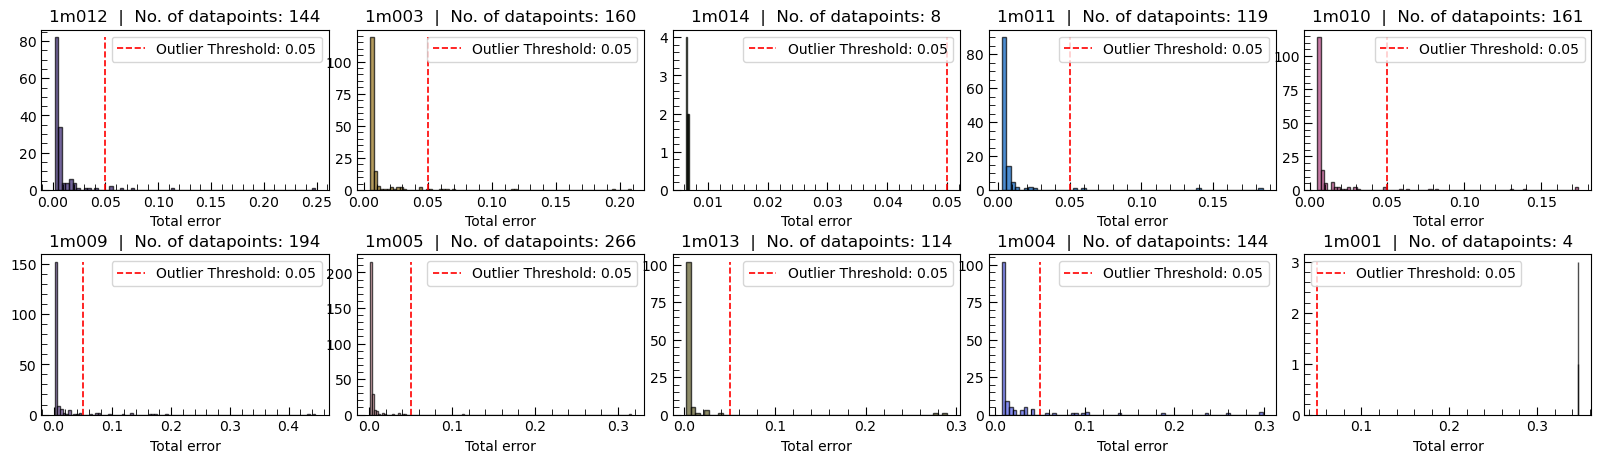

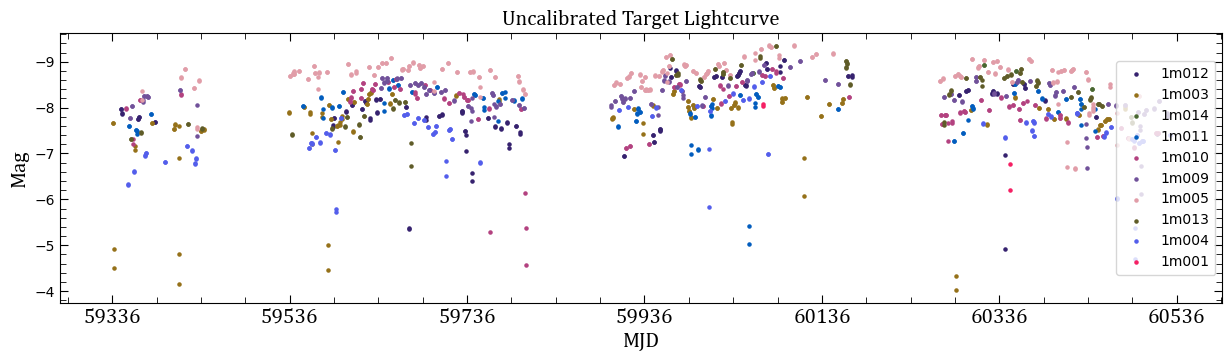

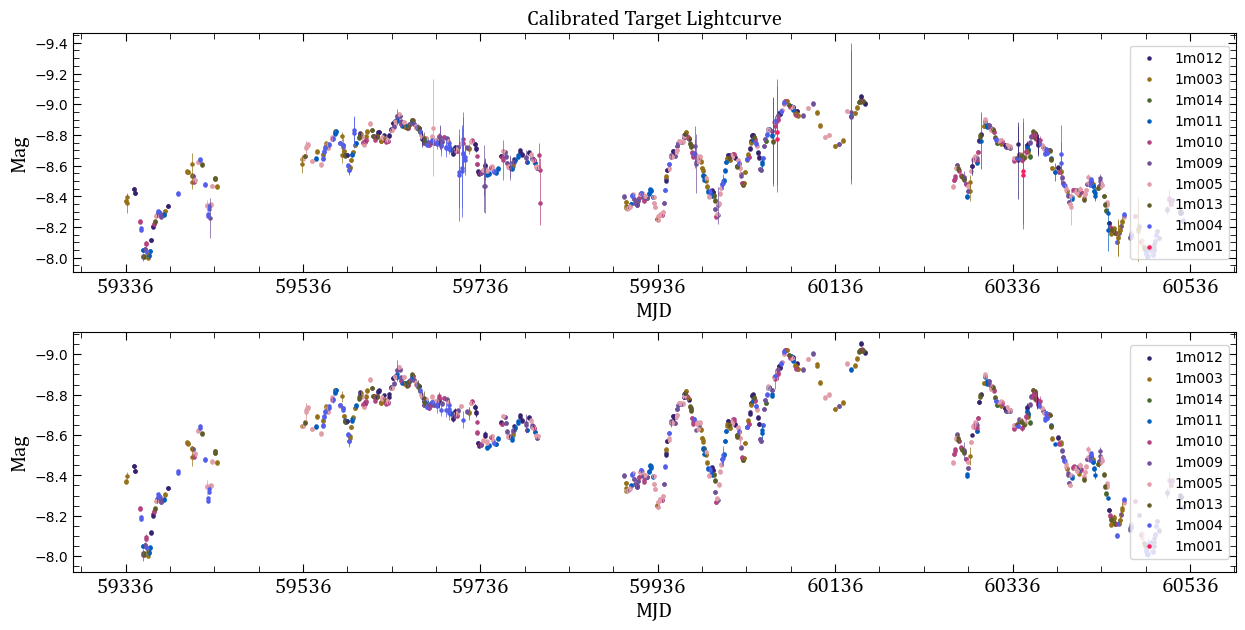

In [12]:
# Calibrate the chosen target using correction parameters derived from the comparison stars.
# you can also input zeropoint if you have one for zp calibration.
Calibrated_Target = Target_Calb(DATA, Calibrated_Stars, 'up', Target_ID = AGN_ID)

In [13]:
Calibrated_Target

,Filter,telid,MJD,mag,err,err_sys
0,up,1m012,59366.706474,-8.209558,0.003364,0.0
1,up,1m012,59366.704775,-8.197511,0.003377,0.0
2,up,1m012,59346.964379,-8.422890,0.002007,0.0
3,up,1m012,59346.960604,-8.421762,0.001986,0.0
4,up,1m012,59345.936723,-8.445274,0.006033,0.0
...,...,...,...,...,...,...
1305,up,1m004,60497.057450,-8.105948,0.008533,0.0
1306,up,1m004,60498.061812,-8.151393,0.008518,0.0
1307,up,1m004,60498.063493,-8.150493,0.008536,0.0
1308,up,1m004,60527.967276,-8.244980,0.008610,0.0


# Done!

# Colour calibrations

To do the first-order colour correction, you need the calibrated target dataframe with at least the two filters used for the colour, AND the filter you want to calibrate. Different dataframes can be easily combined with pd.concat([DF1, DF2], ignore_index = True)

e.g below, I am calibrating B band using the u-g colour index for Fairall 9 (different AGN to above). Both dataframes I'm uploading below are what you'd get from the above calibration functions, just combined for different filters. The AGN has been zeropoint corrected to a standard mag system.

In [9]:
# Our Fairall 9 Example ----------------------------
AGN_DF = pd.read_csv('F9_Calibrated_AGN.csv')
STAR_DF = pd.read_csv('F9_Calibrated_Stars.csv')
AGN_ID = 3019

In [10]:
AGN_DF

,Unnamed: 0.1,Unnamed: 0,Filter,telid,MJD,mag,err,err_sys
0,0,9167.0,B,1m004,58271.423739,14.176532,0.011854,0.036126
1,1,9168.0,B,1m004,58285.347613,14.148897,0.023827,0.036126
2,2,9169.0,B,1m004,58285.421165,14.160800,0.019826,0.036126
3,3,9170.0,B,1m004,58289.362307,14.190578,0.011925,0.036126
4,4,9171.0,B,1m004,58289.363500,14.188726,0.012830,0.036126
...,...,...,...,...,...,...,...,...
29585,29585,NaN,rp,1m013,60537.936821,13.662441,0.004159,0.030334
29586,29586,NaN,rp,1m013,60538.964170,13.648723,0.009994,0.030334
29587,29587,NaN,rp,1m013,60538.964831,13.648434,0.011925,0.030334
29588,29588,NaN,rp,1m013,60541.909098,13.663344,0.030044,0.030334


In [11]:
STAR_DF

,Unnamed: 0.1,Unnamed: 0,id_apass,Filter,MJD,telid,scope_mean,scope_mean_err,mag_aper,err_aper,...,m_star_err,rms_star,rms_star_err,err_tot,DMAGT,DMAGS,DMAGT_err,DMAGS_err,airmass,seeing
0,0,0.0,1279,B,58778.550422,1m011,6.083153,0.001504,-6.419383,0.014866,...,0.000620,0.031003,0.000696,0.035975,0.043046,0.026715,0.001837,0.000049,0.127268,1.608051
1,1,1.0,1279,B,59994.406993,1m011,6.083153,0.001504,-6.404032,0.068751,...,0.000620,0.031003,0.000696,0.075513,0.174010,0.026715,0.001540,0.000049,0.557101,2.427315
2,2,2.0,1279,B,59468.738116,1m011,6.083153,0.001504,-6.388231,0.031644,...,0.000620,0.031003,0.000696,0.044462,0.168452,0.026715,0.000946,0.000049,0.179812,2.692858
3,3,3.0,1279,B,59810.547503,1m011,6.083153,0.001504,-6.438099,0.026511,...,0.000620,0.031003,0.000696,0.041148,-0.112539,0.026715,0.001503,0.000049,0.619985,2.700073
4,4,4.0,1279,B,58758.757522,1m011,6.083153,0.001504,-6.396960,0.015608,...,0.000620,0.031003,0.000696,0.034916,0.001018,0.026715,0.000670,0.000049,0.391731,1.734949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2734264,2734264,NaN,1460,rp,58820.886247,1m012,5.867978,0.000674,-7.366613,0.008795,...,0.000199,0.003892,0.000411,0.010596,-0.357710,0.261963,0.000922,0.000030,0.199996,1.980803
2734265,2734265,NaN,1460,rp,60218.928526,1m012,5.867978,0.000674,-7.363657,0.020425,...,0.000199,0.003892,0.000411,0.020908,-0.217388,0.261963,0.000754,0.000030,0.135839,3.251239
2734266,2734266,NaN,1460,rp,59078.093351,1m012,5.867978,0.000674,-7.362622,0.066119,...,0.000199,0.003892,0.000411,0.066233,2.190679,0.261963,0.001086,0.000030,0.115370,1.405238
2734267,2734267,NaN,1460,rp,59055.987040,1m012,5.867978,0.000674,-7.352469,0.009385,...,0.000199,0.003892,0.000411,0.010160,-0.126927,0.261963,0.000480,0.000030,0.487577,1.723373


In [24]:
Main_Filt = 'B'

Filter1 = 'up'
Filter2 = 'gp'

# Need to calibrate from instrumental mags to standard mag system to get the colours
# The Phot_Cal function is how we compute the zeropoints from apass. You need to obtain the zeropoints for your target.
zp1 = Phot_Cal(STAR_DF, Filter1, catalogue ='F9_apass_pytics.csv')[0]
zp2 = Phot_Cal(STAR_DF, Filter2, catalogue ='F9_apass_pytics.csv')[0]
print(zp1, zp2)

# Add on colour terms to the calibrated star dataframe first =====
DF_with_col = Add_colour(STAR_DF, Filter1, Filter2, zp1 = zp1, zp2 = zp2, Main_Filt = Main_Filt)

22.50007986306332 24.067186935075334
Adding colour terms to dataframe....


C:\Users\rober\AppData\Local\Temp\ipykernel_25784\3057472610.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_with_col.loc[dat_S.index, 'cols'] = cols
C:\Users\rober\AppData\Local\Temp\ipykernel_25784\3057472610.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_with_col.loc[dat_S.index, 'cols_err'] = cols_err


Done



In [13]:
# Colour column added at the end
DF_with_col

,Unnamed: 0.1,Unnamed: 0,id_apass,Filter,MJD,telid,scope_mean,scope_mean_err,mag_aper,err_aper,...,rms_star_err,err_tot,DMAGT,DMAGS,DMAGT_err,DMAGS_err,airmass,seeing,cols,cols_err
19918,19918,19918.0,1218,B,58778.550422,1m011,4.748759,0.000409,-7.714946,0.005680,...,0.000231,0.013175,0.043046,0.026715,0.001837,0.000049,0.127268,1.608051,1.704902,0.000286
19919,19919,19919.0,1218,B,59994.406993,1m011,4.748759,0.000409,-7.759623,0.020388,...,0.000231,0.021431,0.174010,0.026715,0.001540,0.000049,0.557101,2.427315,1.704902,0.000286
19920,19920,19920.0,1218,B,59468.738116,1m011,4.748759,0.000409,-7.735149,0.010521,...,0.000231,0.012422,0.168452,0.026715,0.000946,0.000049,0.179812,2.692858,1.704902,0.000286
19921,19921,19921.0,1218,B,59810.547503,1m011,4.748759,0.000409,-7.736574,0.009293,...,0.000231,0.012033,-0.112539,0.026715,0.001503,0.000049,0.619985,2.700073,1.704902,0.000286
19922,19922,19922.0,1218,B,58758.757522,1m011,4.748759,0.000409,-7.748751,0.005669,...,0.000231,0.008704,0.001018,0.026715,0.000670,0.000049,0.391731,1.734949,1.704902,0.000286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499063,499063,499063.0,1399,B,59248.775406,1m012,4.891769,0.000570,-7.600980,0.016036,...,0.000270,0.017039,-0.022534,0.250908,0.001053,0.000050,0.384589,1.640882,1.320620,0.000275
499064,499064,499064.0,1399,B,59522.768334,1m012,4.891769,0.000570,-7.594986,0.015751,...,0.000270,0.016771,0.211193,0.250908,0.000953,0.000050,0.255322,1.449226,1.320620,0.000275
499065,499065,499065.0,1399,B,59200.781591,1m012,4.891769,0.000570,-7.618691,0.012687,...,0.000270,0.013933,-0.020407,0.250908,0.000896,0.000050,0.120611,1.721436,1.320620,0.000275
499066,499066,499066.0,1399,B,59451.114814,1m012,4.891769,0.000570,-7.597734,0.025440,...,0.000270,0.026084,0.222035,0.250908,0.001214,0.000050,0.133169,1.496328,1.320620,0.000275


# of Stars available in both bands: 30
Computing residuals for heatmap....
0 / 30
1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30


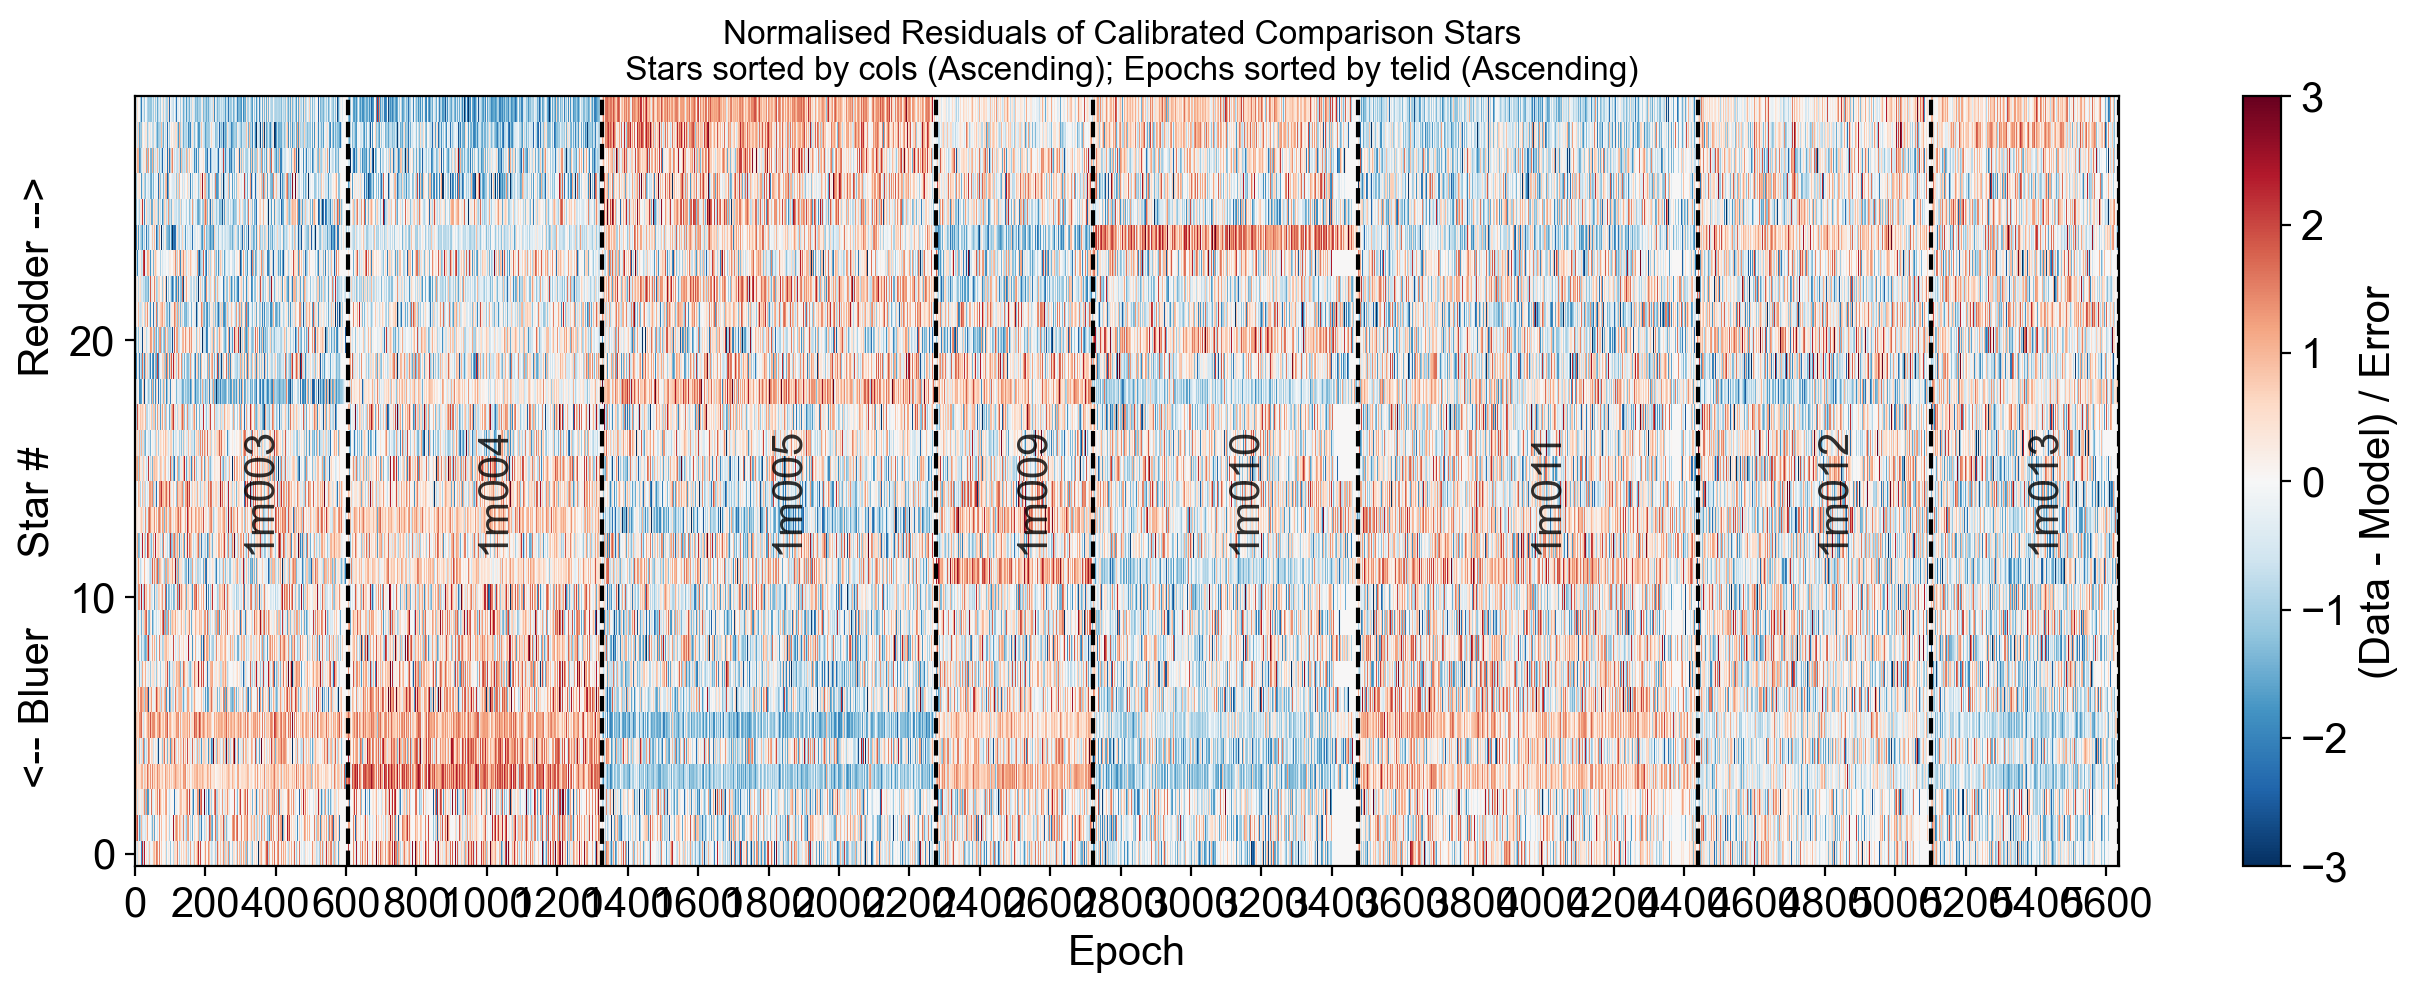

In [14]:
# Plot the residuals to see if there are patterns > sort by colour index (optional)
Heatmap_data(DF_with_col, Filter = Main_Filt, sort_stars_by='cols')

# of Stars available in both bands: 30
Computing residuals for heatmap....
0 / 30
1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30


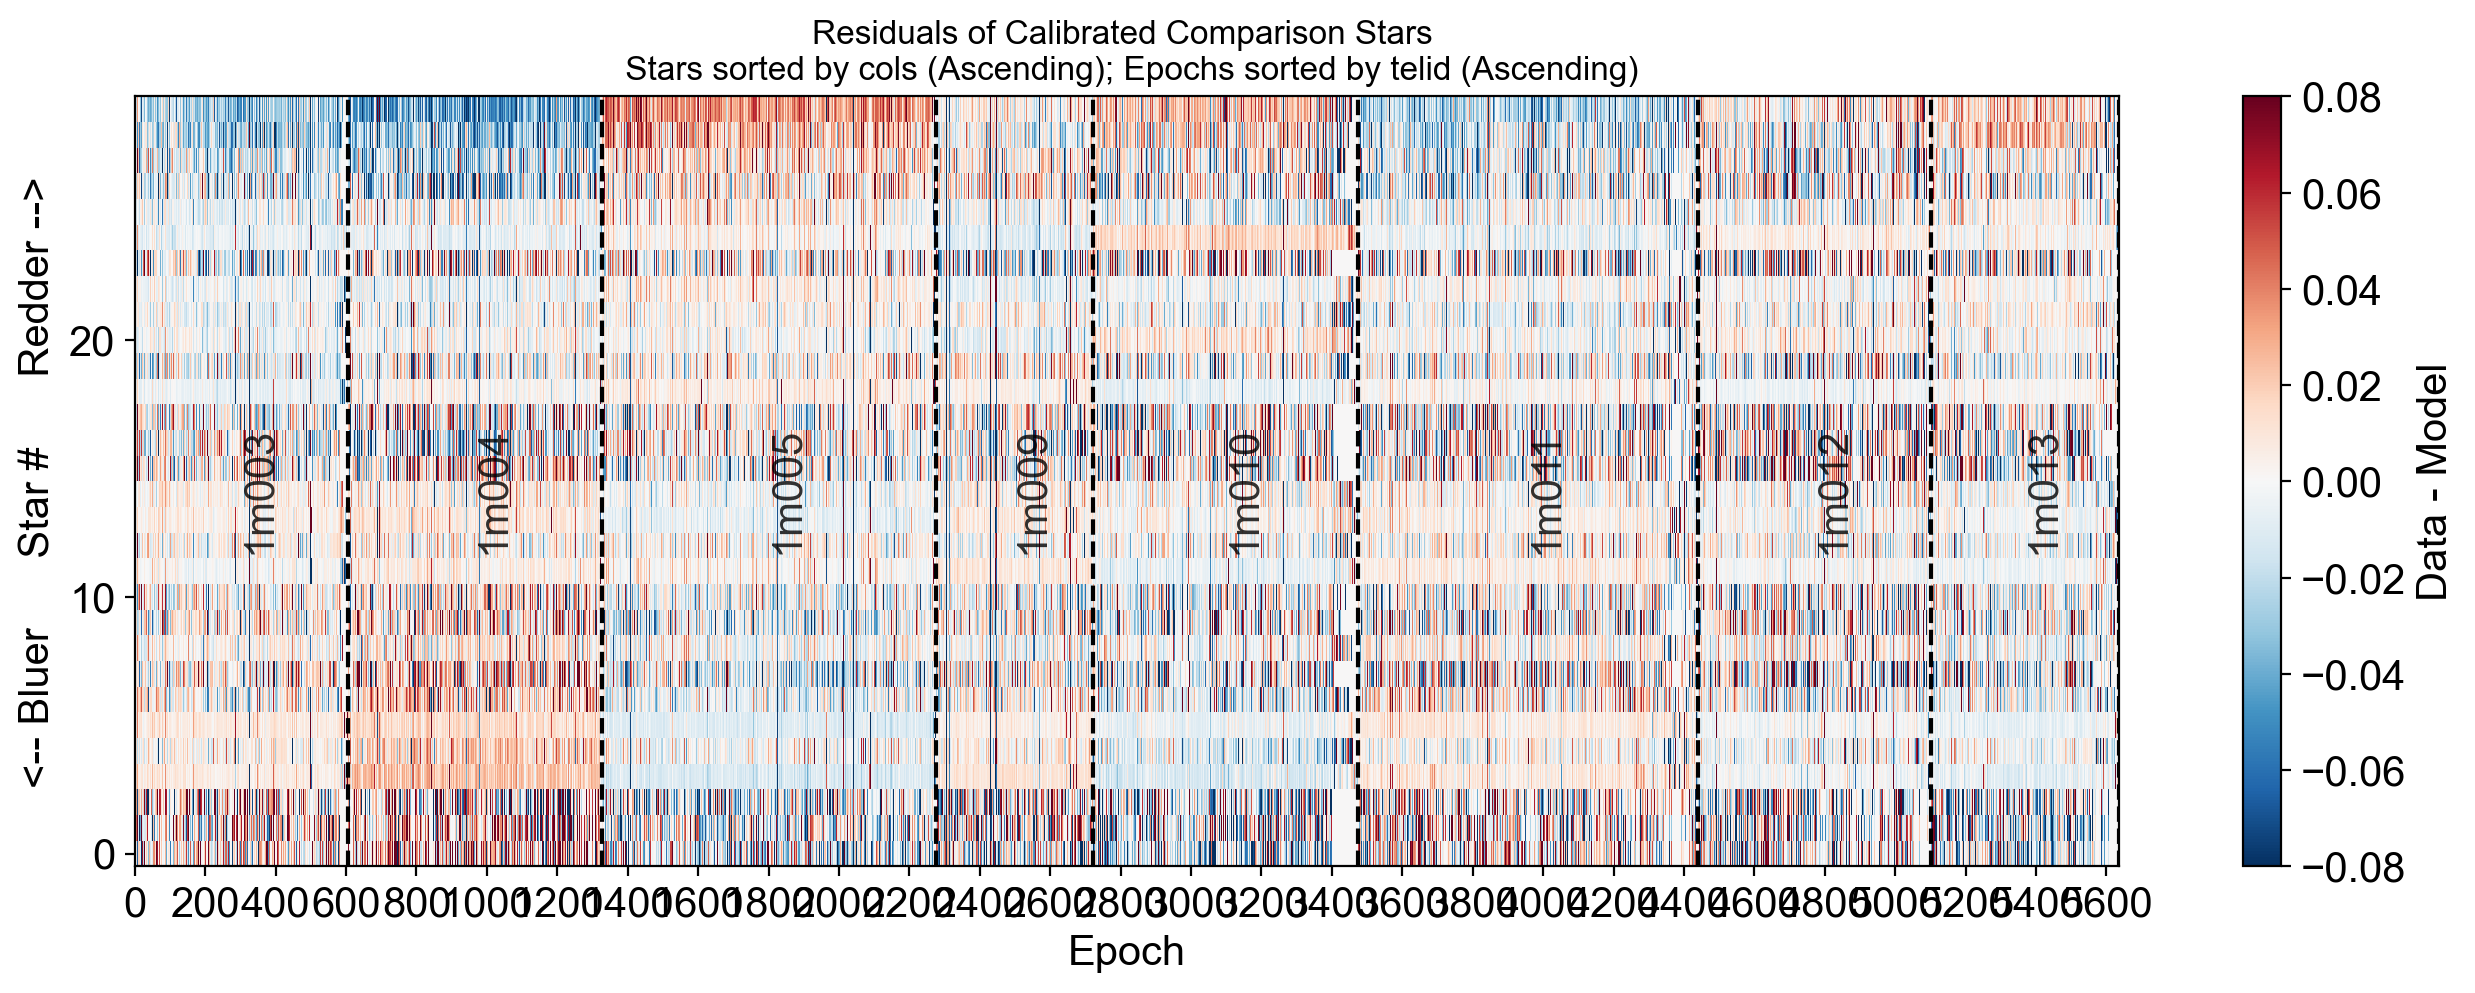

In [15]:
# same as above but non-normalised
Heatmap_data(DF_with_col, Filter = Main_Filt, sort_stars_by='cols', norm = False, vmin = -0.08, vmax = 0.08)

Target up-gp mean colour index: 0.34507149663818737  +-  7.551314885271328e-05

Fitting telescope 1m004 residuals....
Fitting telescope 1m005 residuals....
Fitting telescope 1m012 residuals....
Fitting telescope 1m010 residuals....
Fitting telescope 1m003 residuals....
Fitting telescope 1m011 residuals....
Fitting telescope 1m009 residuals....
Fitting telescope 1m013 residuals....


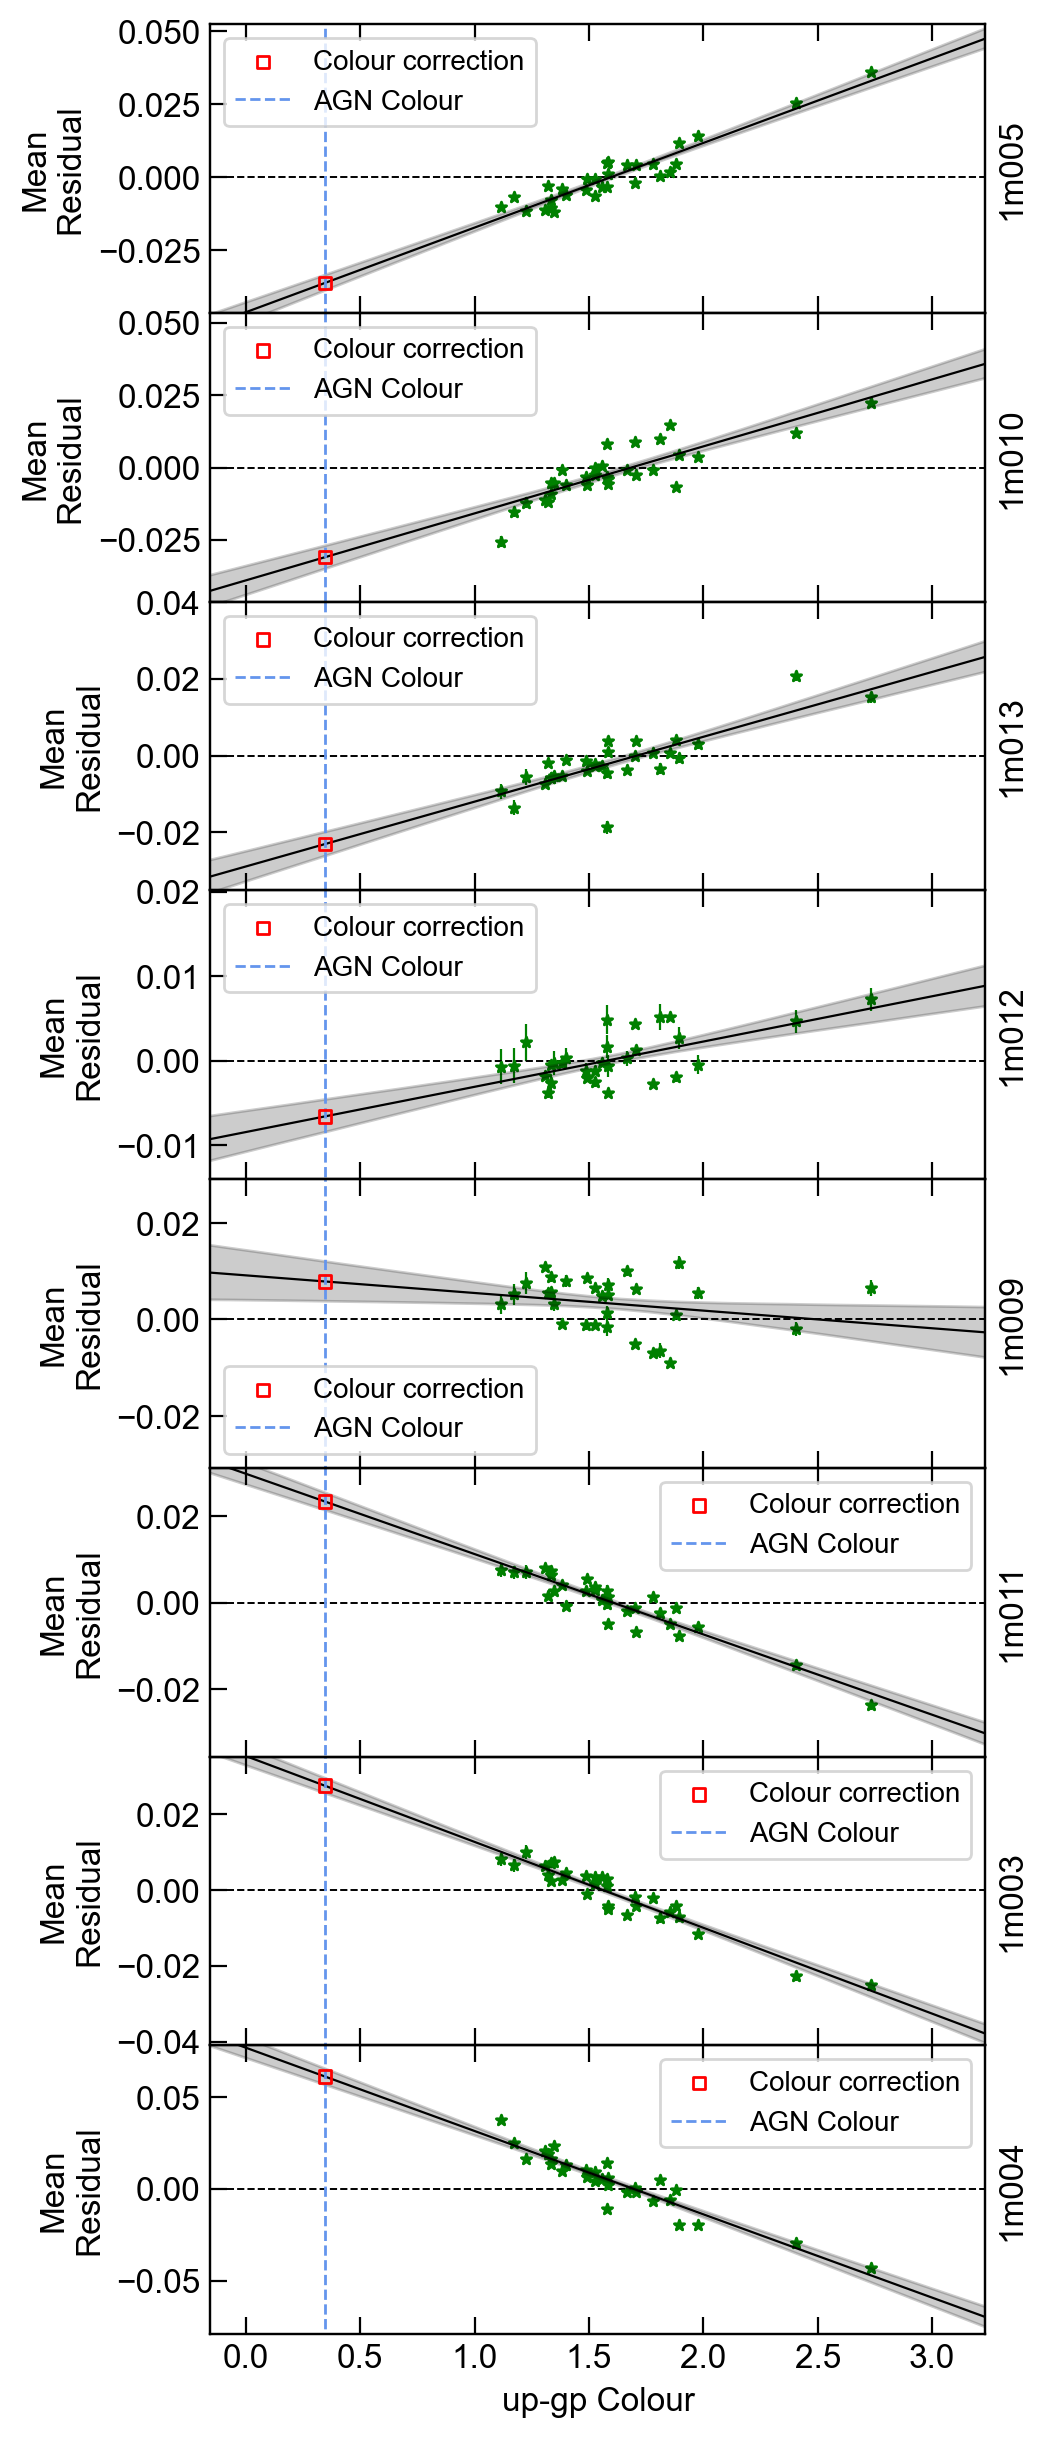

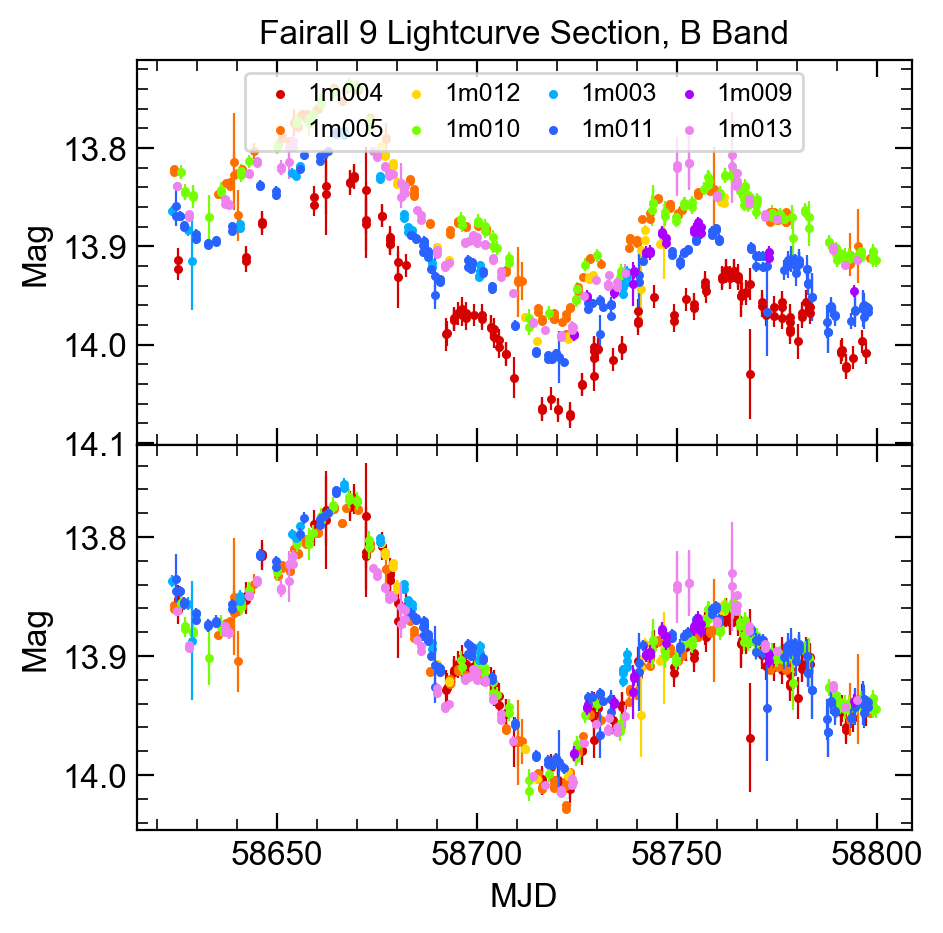

In [16]:
AGN_CC = colour_corr(AGN_DF, DF_with_col, Main_Filt, Filter1, Filter2, plot = True, TD_Col = False, MJD_lims = [58550, 58800], rem_outliers = True)

Computing time dependent colour...
2679 / 2679 epochsTarget up-gp mean colour index: 0.34507149663818737  +-  7.551314885271328e-05

Fitting telescope 1m004 residuals....
Fitting telescope 1m005 residuals....
Fitting telescope 1m012 residuals....
Fitting telescope 1m010 residuals....
Fitting telescope 1m003 residuals....
Fitting telescope 1m011 residuals....
Fitting telescope 1m009 residuals....
Fitting telescope 1m013 residuals....


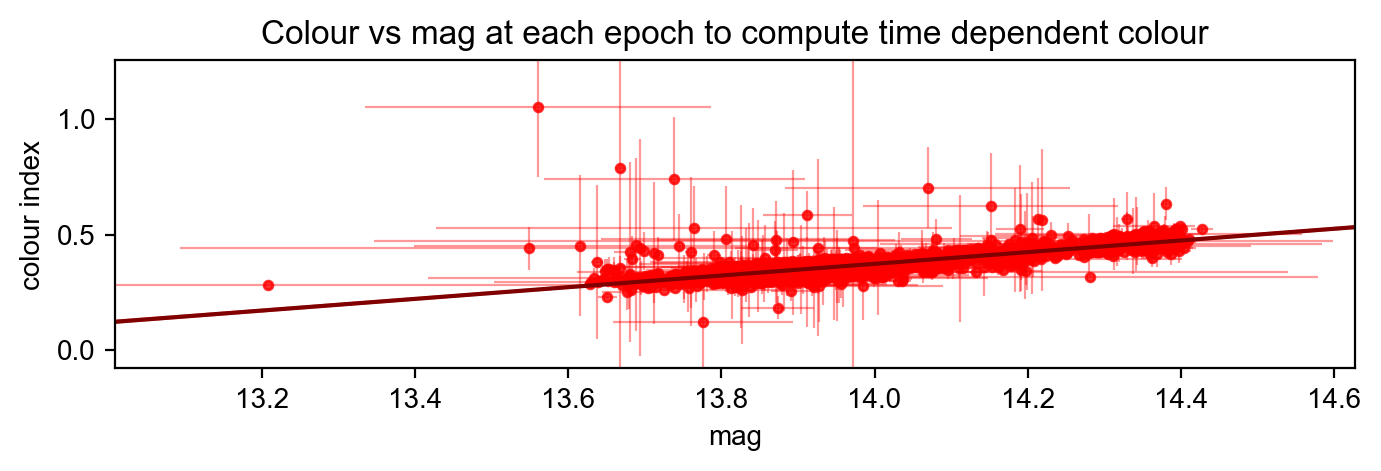

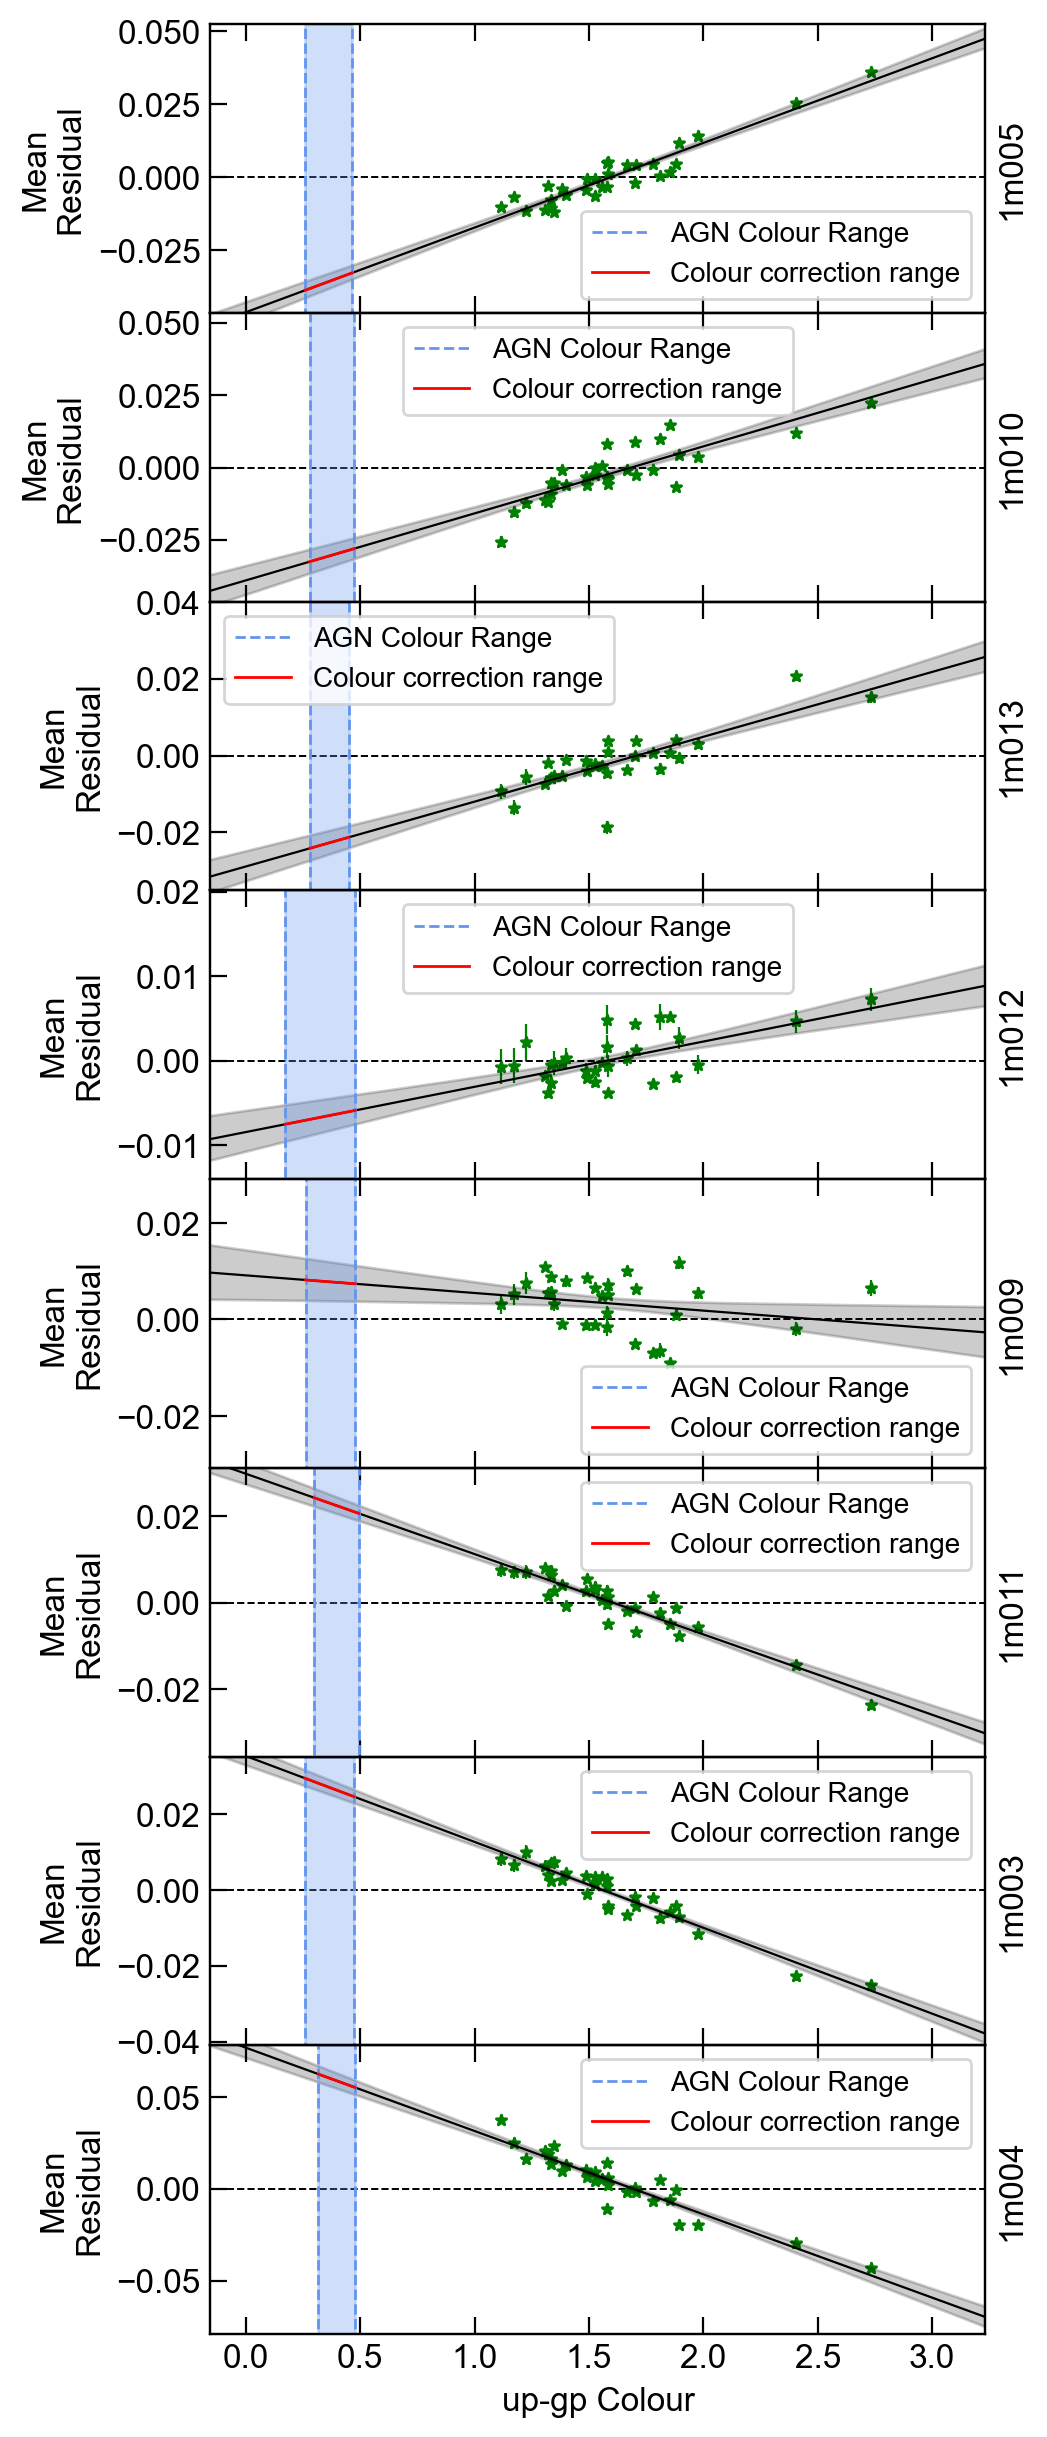

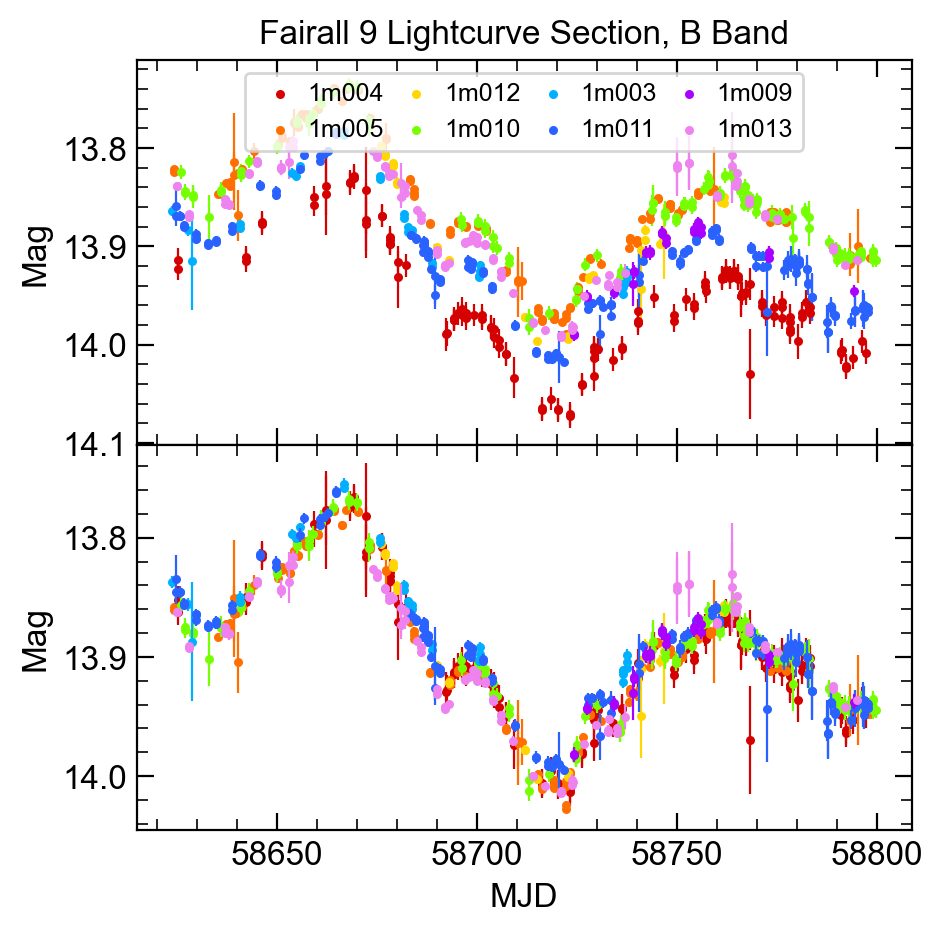

In [17]:
# Time dependent colour correction:
AGN_CC_TD = colour_corr(AGN_DF, DF_with_col, Main_Filt, Filter1, Filter2, plot = True, TD_Col = True, MJD_lims = [58550, 58800], rem_outliers = True)

# Other things you can do

==============================  up Filter  ==============================
Total number of stars available:  148
Max number of epochs amongst all stars: 1314


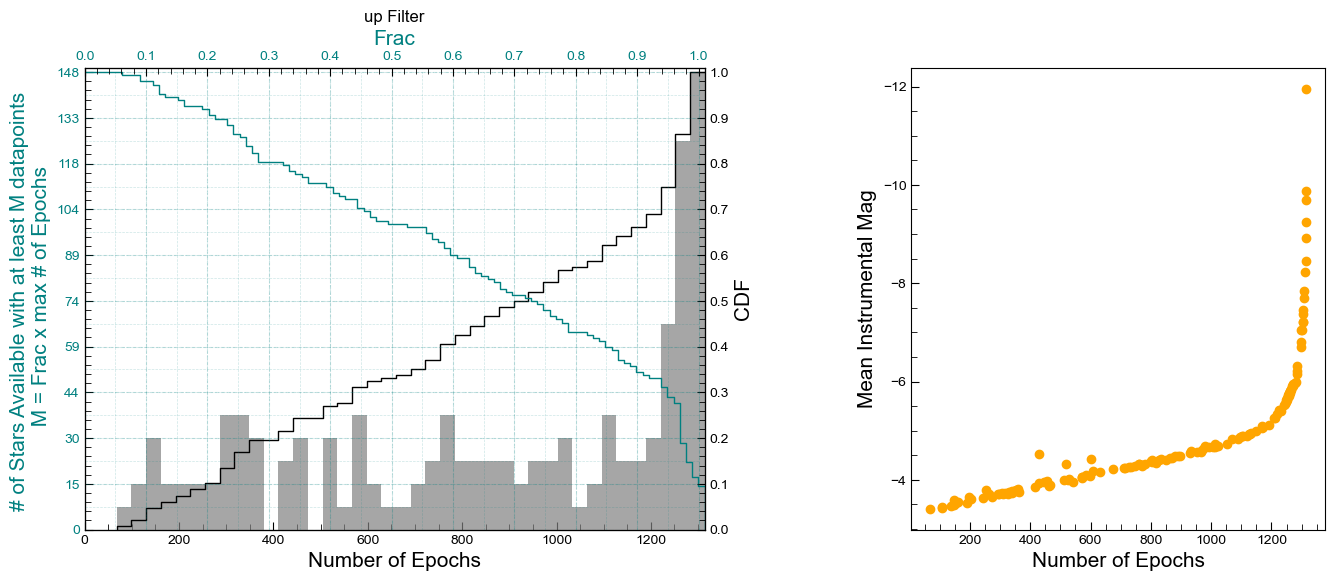

In [18]:
# Inspect the properties of your chosen stars before calibration, and how many epoch are available in general.
# This may guide you to choose the frac limit when selecting your ensemble of stars.
Epoch_Dist(DATA, 'up', Target_ID = AGN_ID)

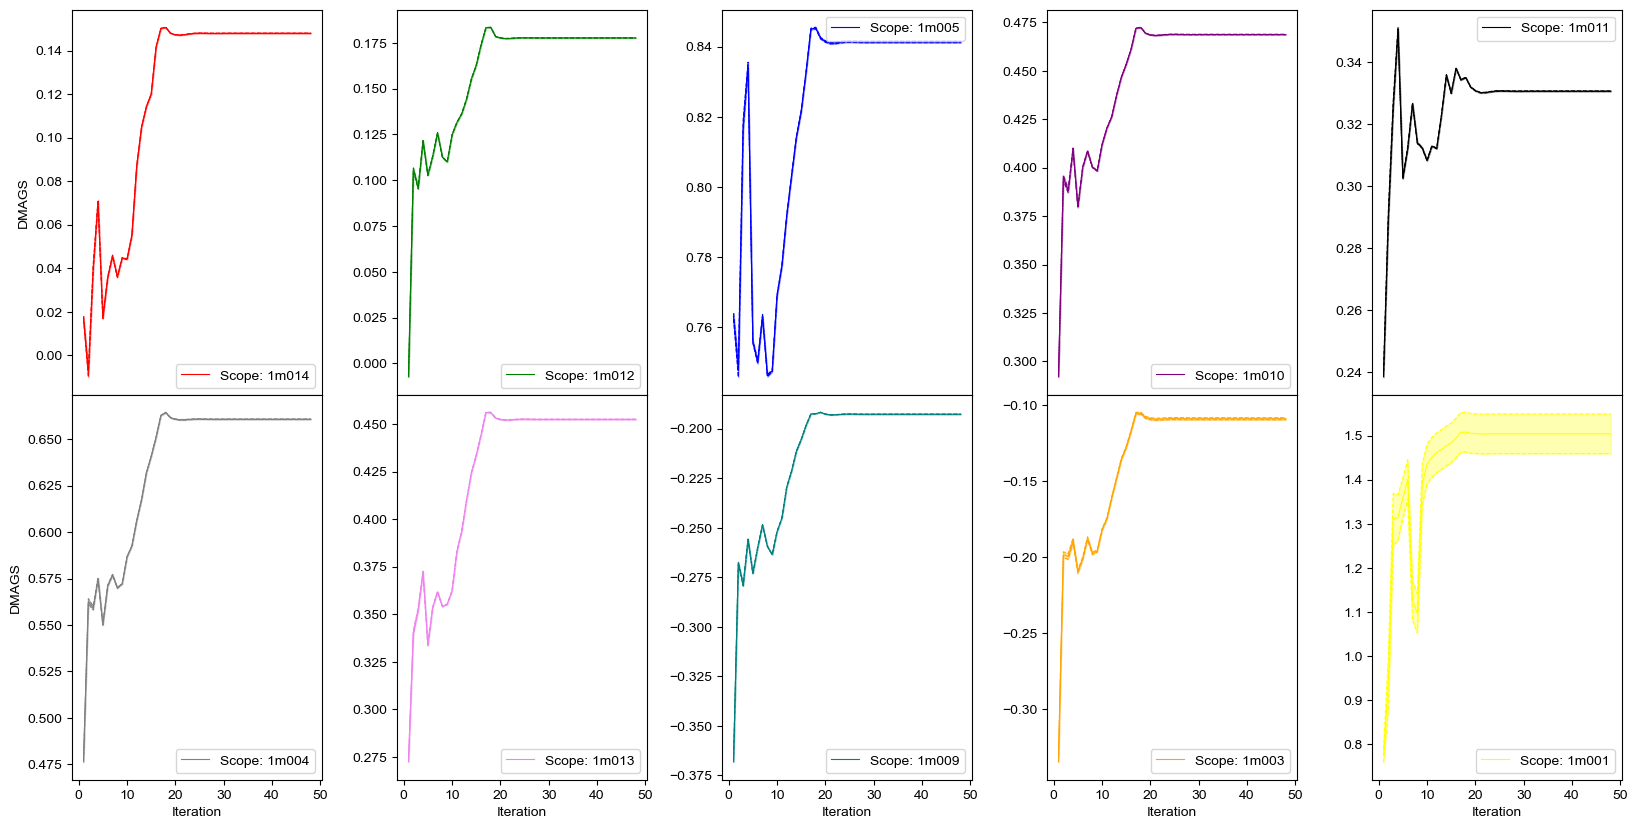

In [19]:
# Check visually converge after the star calibration
Convergence_Plot(Calibrated_Stars_Trace, 'double', 'DMAGS', TEL = pd.unique(Calibrated_Stars.telid), parameter_err = 'DMAGS_err')

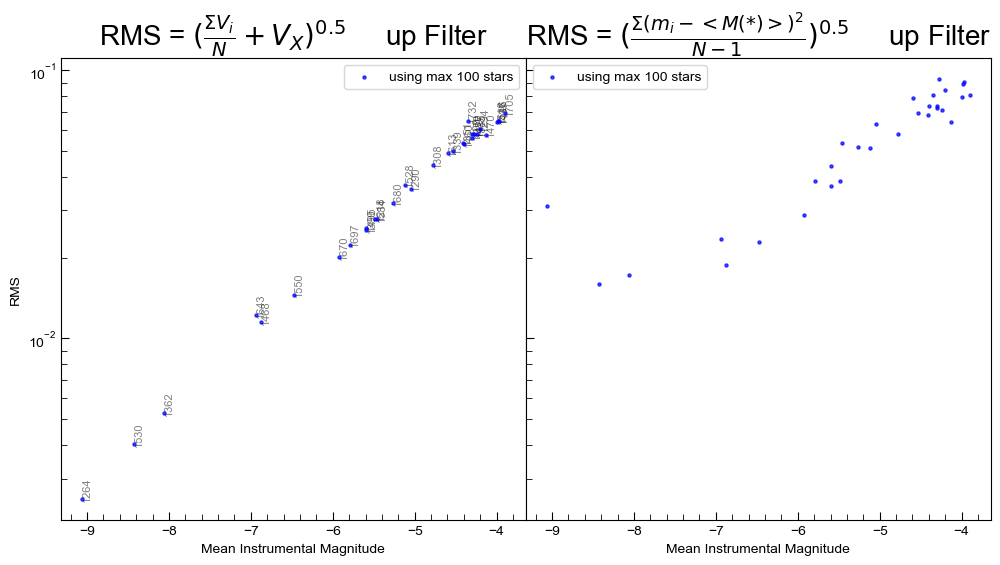

In [20]:
# Create rms vs magnitude plot to identify variable stars (post calibration)
Detect_Var(STAR_DF, 'up', Label = True, Target_ID = AGN_ID)